In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from scipy.stats import ttest_ind
import math
from scipy.stats import pearsonr, spearmanr
import plotly.graph_objects as go
import plotly.express as px
from sklearn.impute import SimpleImputer, KNNImputer
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
import pickle
import matplotlib.patches as mpatches
from sklearn.linear_model import LinearRegression

In [2]:
pd.options.display.max_columns = 50
plt.rc('font', family='Helvetica')
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2

In [3]:
seed = 42

In [4]:
meta = pd.read_csv("../data/E0022_P06_final_sample_map_no_control.txt",
                   sep='\t')
ic50 = pd.read_csv("../data/drug/drug_final_processed.csv.gz", low_memory=False)
protein_sample = pd.read_csv(
    "../data/protein/E0022_P06_Protein_Matrix_ProNorM_no_control_update.txt",
    sep='\t')

In [5]:
tissue_type_map = meta[[
    'Cell_line', 'Cancer_type', 'Tissue_type'
]].drop_duplicates().set_index('Cell_line').to_dict()['Tissue_type']

In [6]:
ic50['Tissue_type'] = ic50['cell_line_name'].map(tissue_type_map)

# compute

## load data

In [7]:
meta = pd.read_csv("../data/E0022_P06_final_sample_map_no_control.txt", sep='\t')

In [8]:
protein_RUV = pd.read_csv(
    "../data/protein/E0022_P06_Protein_Matrix_ProNorM_no_control_update.txt",
    sep='\t').sort_values(by=['Cell_line'])
rna_sample = pd.read_csv('../data/rna/rna_common.tsv', sep='\t')

In [9]:
common_cell_lines = set(protein_RUV['Cell_line']).intersection(set(rna_sample['Cell_line']))

In [10]:
proteins = [x for x in protein_RUV.columns if '_HUMAN' in x]

In [11]:
protein_RUV[proteins] = protein_RUV[proteins].fillna(-2.242616)

In [12]:
protein_sample_impute = protein_sample
protein_sample_impute[proteins] = protein_sample[proteins].fillna(-2.242616)

In [13]:
ic50 = pd.read_csv("../data/drug/drug_final_processed_eg_id.csv.gz", low_memory=False)

In [14]:
ic50_counts = ic50.groupby(['drug_id']).size()
selected_drugs = ic50_counts[ic50_counts > 300].index.values

In [15]:
ic50 = ic50[ic50['drug_id'].isin(selected_drugs)].reset_index(drop=True)

In [16]:
ic50_noblood = ic50[
    ic50['tissue'] != 'Haematopoietic and Lymphoid'].reset_index(drop=True)
ic50_noblood_common = ic50_noblood[ic50_noblood['cell_line_name'].isin(
    common_cell_lines)].reset_index(drop=True)

In [17]:
def run_corr_pancancer(drug_id, data_sample, ic50=ic50):
    res_df = []
    tmp_df = ic50[ic50['drug_id'] == drug_id].sort_values(
        by=['cell_line_name'])
    cell_line_drug = tmp_df['cell_line_name'].values
    protein_drug = data_sample[data_sample['Cell_line'].isin(cell_line_drug)]
    ic50_drug = tmp_df[tmp_df['cell_line_name'].isin(
        protein_drug['Cell_line'])]['ln_IC50'].values

    for protein in protein_drug.columns:
        if protein == 'Cell_line':
            continue
        protein_drug_tissue_protein = protein_drug[protein].values
        ic50_drug_tissue_protein = ic50_drug
        ic50_drug_tissue_protein = ic50_drug_tissue_protein[
                ~np.isnan(protein_drug_tissue_protein)]
        protein_drug_tissue_protein = protein_drug_tissue_protein[
            ~np.isnan(protein_drug_tissue_protein)]
        if protein_drug_tissue_protein.size <= 2:
            continue
        p_corr, p_pval = pearsonr(protein_drug_tissue_protein,
                                      ic50_drug_tissue_protein)
        s_corr, s_pval = spearmanr(protein_drug_tissue_protein,
                                   ic50_drug_tissue_protein)
        res_df.append({
            'drug_id': drug_id,
            'protein': protein,
            'pearson_correlation': p_corr,
            'pearson_pval': p_pval,
            'spearman_correlation': s_corr,
            'spearman_pval': s_pval,
            'count': protein_drug_tissue_protein.size
        })
    res_df = pd.DataFrame(res_df)
    return res_df

In [18]:
def run_corr(drug_id, data_sample, ic50=ic50):
    res_df = []
    tmp_df = ic50[ic50['drug_id'] == drug_id].sort_values(
        by=['cell_line_name'])
    cell_line_drug = tmp_df['cell_line_name'].values
    gene_drug = data_sample[data_sample['Cell_line'].isin(cell_line_drug)]
    ic50_drug = tmp_df[tmp_df['cell_line_name'].isin(
        gene_drug['Cell_line'])]
    for tissue, cell_lines in tissue_cell_line.items():
        gene_drug_tissue = gene_drug[gene_drug['Cell_line'].isin(
            cell_lines)]
        ic50_drug_tissue = ic50_drug[ic50_drug['cell_line_name'].isin(
            cell_lines)]
        for gene in gene_drug.columns:
            if gene == 'Cell_line':
                continue
            gene_drug_tissue_gene = gene_drug_tissue[gene].values
            ic50_drug_tissue_gene = ic50_drug_tissue['ln_IC50'].values
            if gene_drug_tissue_gene.size <= 2:
                continue
            # TODO filter out nan
            ic50_drug_tissue_gene = ic50_drug_tissue_gene[
                ~np.isnan(gene_drug_tissue_gene)]
            gene_drug_tissue_gene = gene_drug_tissue_gene[
                ~np.isnan(gene_drug_tissue_gene)]
            p_corr, p_pval = pearsonr(gene_drug_tissue_gene,
                                      ic50_drug_tissue_gene)
            s_corr, s_pval = spearmanr(gene_drug_tissue_gene,
                                       ic50_drug_tissue_gene)
            res_df.append({
                'drug_id': drug_id,
                'gene': gene,
                'tissue': tissue,
                'pearson_correlation': p_corr,
                'pearson_pval': p_pval,
                'spearman_correlation': s_corr,
                'spearman_pval': s_pval,
                'count': gene_drug_tissue_gene.size
            })
    res_df = pd.DataFrame(res_df)
    return res_df

In [30]:
name_map = pd.read_csv("../data/misc/HUMAN_9606_idmapping.gene_prot.dat",
                       sep='\t',
                       names=['ID', 'type', 'code'])
name_map = name_map.drop_duplicates(['ID', 'type'])
name_map = pd.pivot(name_map, index='ID', columns='type', values='code').dropna()

protein2rna_map = dict(zip(name_map['UniProtKB-ID'].values, name_map['Gene_Name'].values))
rna2protein_map = {v: k for k, v in protein2rna_map.items()}

## protein

### pan-cancer

In [23]:
res_pancancer = Parallel(n_jobs=10)(delayed(run_corr_pancancer)(i, protein_RUV)
                          for i in tqdm_notebook(selected_drugs))
res_pancancer_all = pd.concat(res_pancancer).sort_values(by=['pearson_pval'])

<ipython-input-23-a6945da1efcb>:2: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/Users/scai/anaconda3/envs/sanger/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



In [215]:
res_pancancer_noblood = Parallel(n_jobs=10)(delayed(run_corr_pancancer)(i, protein_RUV, ic50_noblood)
                          for i in tqdm_notebook(selected_drugs))
res_pancancer_noblood_all = pd.concat(res_pancancer_noblood).sort_values(by=['pearson_pval'])

/Users/scai/anaconda3/envs/sklearn22/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



In [253]:
res_pancancer_noblood_common = Parallel(n_jobs=10)(delayed(run_corr_pancancer)(i, protein_RUV, ic50_noblood_common)
                          for i in tqdm_notebook(selected_drugs))
res_pancancer_noblood_common_all = pd.concat(res_pancancer_noblood_common).sort_values(by=['pearson_pval'])

/Users/scai/anaconda3/envs/sklearn22/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



In [25]:
pickle.dump(res_pancancer_all, open("../data/correlation/res_pancancer.pkl", "wb"))

### tissue specific

In [19]:
tissue_cell_line = {}
for tissue in meta['Tissue_type'].unique():
    tissue_cell_line[tissue] = meta[meta['Tissue_type']==tissue]['Cell_line'].values

In [23]:
res = Parallel(n_jobs=10)(delayed(run_corr)(i, protein_RUV)
                          for i in tqdm(selected_drugs))
res_all = pd.concat(res).sort_values(by=['pearson_pval'])

/Users/scai/anaconda3/envs/sanger/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



In [34]:
pickle.dump(res_all, open("../data/correlation/res_tissue_level.pkl", "wb"))

In [32]:
res_all['gene'] = res_all['gene'].map(protein2rna_map)

## RNA

In [42]:
name_map = pd.read_csv("../data/misc/HUMAN_9606_idmapping.gene_prot.dat",
                       sep='\t',
                       names=['ID', 'type', 'code'])
name_map = name_map.drop_duplicates(['ID', 'type'])
name_map = pd.pivot(name_map, index='ID', columns='type', values='code').dropna()

name_map_dict = dict(zip(name_map['UniProtKB-ID'].values, name_map['Gene_Name'].values))

In [40]:
res_rna_pancancer = Parallel(n_jobs=10)(delayed(run_corr_pancancer)(i, rna_sample)
                          for i in tqdm_notebook(selected_drugs))
res_all_rna_pancancer = pd.concat(res_rna_pancancer).sort_values(by=['pearson_pval'])

/Users/scai/anaconda3/envs/sklearn22/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



In [217]:
res_rna_pancancer_noblood = Parallel(n_jobs=10)(delayed(run_corr_pancancer)(i, rna_sample, ic50_noblood)
                          for i in tqdm_notebook(selected_drugs))
res_all_rna_pancancer_noblood = pd.concat(res_rna_pancancer_noblood).sort_values(by=['pearson_pval'])

/Users/scai/anaconda3/envs/sklearn22/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



In [254]:
res_rna_pancancer_noblood_common = Parallel(n_jobs=10)(delayed(run_corr_pancancer)(i, rna_sample, ic50_noblood_common)
                          for i in tqdm_notebook(selected_drugs))
res_all_rna_pancancer_noblood_common = pd.concat(res_rna_pancancer_noblood_common).sort_values(by=['pearson_pval'])

/Users/scai/anaconda3/envs/sklearn22/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



In [255]:
pickle.dump(res_all_rna_pancancer_noblood_common, open("../data/correlation/res_pancancer_noblood_common_rna.pkl", "wb"))

In [17]:
res_rna = Parallel(n_jobs=10)(delayed(run_corr)(i, rna_sample)
                          for i in tqdm_notebook(selected_drugs))
res_all_rna = pd.concat(res_rna).sort_values(by=['pearson_pval'])

/Users/scai/anaconda3/envs/sklearn22/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



In [18]:
pickle.dump(res_all_rna, open("../data/correlation/res_all_rna.pkl", "wb"))

# specific protein

In [379]:
drug_id = 1005
protein = 'ABCF2_HUMAN'

tmp_df = ic50[ic50['drug_id'] == drug_id].sort_values(
        by=['cell_line_name'])
cell_line_drug = tmp_df['cell_line_name'].values
protein_drug = protein_RUV[protein_RUV['Cell_line'].isin(cell_line_drug)]
ic50_drug = tmp_df[tmp_df['cell_line_name'].isin(
    protein_drug['Cell_line'])]['ln_IC50'].values
protein_drug_tissue_protein = protein_drug[protein].values
ic50_drug_tissue_protein = ic50_drug
ic50_drug_tissue_protein = ic50_drug_tissue_protein[
        ~np.isnan(protein_drug_tissue_protein)]
protein_drug_tissue_protein = protein_drug_tissue_protein[
    ~np.isnan(protein_drug_tissue_protein)]

p_corr, p_pval = pearsonr(protein_drug_tissue_protein,
                              ic50_drug_tissue_protein)
s_corr, s_pval = spearmanr(protein_drug_tissue_protein,
                           ic50_drug_tissue_protein)
print(p_corr, p_pval)

-0.14196886407741752 1.73753326479654e-05


# load data

In [7]:
res_all = pickle.load(open("../data/correlation/res_all.pkl", "rb"))
res_df = pickle.load(open("../data/correlation/res_pancancer.pkl", "rb"))

In [29]:
drug_meta = pd.read_csv("../data/drug/archive/screened_compunds_rel_8.2.csv")

target_pathway_dict = drug_meta[[
    'DRUG_ID', 'TARGET_PATHWAY'
]].drop_duplicates().set_index(['DRUG_ID']).to_dict()['TARGET_PATHWAY']

In [9]:
res_all['target_pathway'] = res_all['drug_id'].map(target_pathway_dict)
res_df['target_pathway'] = res_df['drug_id'].map(target_pathway_dict)

In [10]:
res_all_filtered = res_all[res_all['count']>5]
res_df_filtered = res_df[res_df['count']>5]

In [32]:
drug_score = pd.read_csv("../data/drug/final_drug_scores.tsv", sep="\t")
drug_list = drug_score[
    (drug_score['MultiDrug_correlation'] > 0.4) & (drug_score['sensitive_count'] > 20)][
    'drug_id'].values
drug_list_sensitive = drug_score[(drug_score['sensitive_count'] > 20)][
    'drug_id'].values

In [37]:
drug_name_map = drug_score[[
    'drug_id', 'drug_name'
]].drop_duplicates().set_index('drug_id').to_dict()['drug_name']
drug_target_map = drug_score[[
    'drug_id', 'putative_gene_target'
]].drop_duplicates().set_index('drug_id').to_dict()['putative_gene_target']

In [13]:
res_all_filtered = res_all_filtered[res_all_filtered['drug_id'].isin(drug_list)]
res_df_filtered = res_df_filtered[res_df_filtered['drug_id'].isin(drug_list)]

# analysis

In [14]:
target_pathway_color = dict(
    zip(sorted(res_all_filtered['target_pathway'].unique()),
        sns.color_palette('hls', n_colors=len(res_all_filtered['target_pathway'].unique()))))

In [15]:
legend_TN = [mpatches.Patch(color=c, label=l) for l,c in target_pathway_color.items()]

## functions

In [16]:
def heatmap(protein):
    res_all_filtered_protein = res_all_filtered[res_all_filtered['protein'] ==
                                                protein]
    res_df_filtered_protein = res_df_filtered[res_df_filtered['protein'] ==
                                              protein]

    tmp_df = pd.pivot(res_all_filtered_protein.groupby(
        ['tissue',
         'drug_id'])['pearson_correlation'].mean().sort_values().reset_index(),
                      index='drug_id',
                      columns='tissue')
    tmp_df.columns = [
        x[1].replace('pearson_correlation-', '') for x in tmp_df.columns
    ]
    tmp_df = tmp_df.dropna()
    g = sns.clustermap(tmp_df,
                       cmap='coolwarm',
                       figsize=(12, 12),
                       cbar_pos=(0.02, 0.85, 0.05, 0.12),
                       vmin=-1,
                       vmax=1,
                       row_colors=tmp_df.index.map(target_pathway_dict).map(
                           target_pathway_color))
    l2 = g.ax_heatmap.legend(loc='center left',
                             bbox_to_anchor=(1.08, 0.03),
                             handles=legend_TN,
                             frameon=True,
                             fontsize=10)

    protein = protein.replace('_HUMAN', '')
    g.fig.suptitle(f'Correlation {protein}/ln_IC50')
    plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, ha='right')
    plt.show()

In [17]:
def heatmap_drug_one(protein, drug_id):
    res_all_filtered_protein = res_all_filtered[res_all_filtered['protein']==protein]
    res_df_filtered_protein = res_df_filtered[res_df_filtered['protein']==protein]
    res_all_filtered_protein_drug = res_all_filtered_protein[
    res_all_filtered_protein['drug_id'] == drug]
    tmp_df = pd.pivot(res_all_filtered_protein_drug.groupby(
        ['tissue',
         'drug_id'])['pearson_correlation'].mean().sort_values().reset_index(),
                      index='drug_id',
                      columns='tissue')
    tmp_df.columns = [
        x[1].replace('pearson_correlation-', '') for x in tmp_df.columns
    ]
    tmp_df.index = [f'{tmp_df.index.values[0]} - {drug_name_map[tmp_df.index[0]]}']
    g = sns.clustermap(tmp_df,
                       cmap='coolwarm',
                       figsize=(16, 2),
                       cbar_pos=(0.3, 0.85, 0.01, 0.3),
                       vmin=-1,
                       vmax=1,
                       row_cluster=False,
                       annot=True,
                       fmt='.2f')
    protein = protein.replace('_HUMAN', '')
    g.fig.suptitle(f'Correlation {protein}/ln_IC50')
    plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, ha='right')
    plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, va='center')

    plt.show()

In [18]:
def drug_scatter_all(protein):
    protein_map = protein_sample.set_index('Cell_line').to_dict()[protein]

    tmp_ic50 = ic50[['drug_id', 'cell_line_name', 'ln_IC50','Tissue_type']]

    tmp_ic50 = tmp_ic50[tmp_ic50['drug_id'].isin(drug_list)]

    tmp_ic50['protein_abundance'] = tmp_ic50['cell_line_name'].map(protein_map)

    plt.figure(figsize=(12,10))
    tmp_ic50 = tmp_ic50.dropna()
    r, pval = pearsonr(tmp_ic50['protein_abundance'], tmp_ic50['ln_IC50'])
    tmp_ic50 = tmp_ic50.sample(frac=0.01)
    sns.scatterplot(x='protein_abundance', y='ln_IC50', hue='Tissue_type', data=tmp_ic50)
    plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
    plt.text(tmp_ic50['protein_abundance'].min()*0.9, tmp_ic50['ln_IC50'].max()*0.9, f'R={r:.4f}, pval={pval:.4e}')

In [36]:
def drug_scatter_one(gene, drug, sample_data, ic50=ic50, x=0.8, y=0.8):
    gene_map = sample_data.set_index('Cell_line').to_dict()[f'{gene}']

    tmp_ic50 = ic50[['drug_id', 'cell_line_name', 'ln_IC50', 'Tissue_type']]

    tmp_ic50['gene_abundance'] = tmp_ic50['cell_line_name'].map(gene_map)
    tmp_ic50 = tmp_ic50[tmp_ic50['drug_id'] == drug]
    tmp_ic50 = tmp_ic50.dropna()
#     tmp_ic50 = tmp_ic50[tmp_ic50['cell_line_name'].isin(common_cell_lines)]
    num_points = tmp_ic50['cell_line_name'].unique().size

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)
    sns.scatterplot(x='gene_abundance',
                    y='ln_IC50',
                    hue='Tissue_type',
                    hue_order=sorted(tmp_ic50['Tissue_type'].unique()),
                    data=tmp_ic50,
                    linewidth=0.1,
                    edgecolor='b',
                    alpha=0.9)
    reg = LinearRegression()
    reg.fit(tmp_ic50['gene_abundance'].values.reshape(-1, 1), tmp_ic50['ln_IC50'])
    y_pred = reg.predict(tmp_ic50['gene_abundance'].values.reshape(-1, 1))
    plt.plot(tmp_ic50['gene_abundance'], y_pred, color='red')
    r, pval = pearsonr(tmp_ic50['gene_abundance'], tmp_ic50['ln_IC50'])
    plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0., prop={'size': 10})

    plt.text(x,
             y,
             f'R={r:.4f}, pval={pval:.2e}',
             ha='center',
             va='center',
             transform=ax.transAxes,
             fontdict={'size': 16})
    plt.title(
        f"{gene}/ln_IC50 for drug_id {drug} - {drug_name_map[drug]} (n={num_points})"
    )
    plt.xlabel(f"{gene} abundance")

In [20]:
def drug_scatter_one_tissue(gene,
                            drug,
                            sample_data,
                            tissue_list,
                            ic50=ic50,
                            x=0.8,
                            y=0.8):
    gene_map = sample_data.set_index('Cell_line').to_dict()[f'{gene}']

    tmp_ic50 = ic50[['drug_id', 'cell_line_name', 'ln_IC50', 'Tissue_type']]

    tmp_ic50['gene_abundance'] = tmp_ic50['cell_line_name'].map(gene_map)
    tmp_ic50 = tmp_ic50[tmp_ic50['drug_id'] == drug]
    tmp_ic50 = tmp_ic50.dropna()
    tmp_ic50 = tmp_ic50[(tmp_ic50['drug_id'] == drug)
                        & (tmp_ic50['Tissue_type'].isin(tissue_list))]
    num_points = tmp_ic50['cell_line_name'].unique().size

    r, pval = pearsonr(tmp_ic50['gene_abundance'], tmp_ic50['ln_IC50'])
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)
    sns.scatterplot(x='gene_abundance',
                    y='ln_IC50',
                    hue='Tissue_type',
                    data=tmp_ic50)
    reg = LinearRegression()
    reg.fit(tmp_ic50['gene_abundance'].values.reshape(-1, 1), tmp_ic50['ln_IC50'])
    y_pred = reg.predict(tmp_ic50['gene_abundance'].values.reshape(-1, 1))
    plt.plot(tmp_ic50['gene_abundance'], y_pred, color='red')
    plt.text(x,
             y,
             f'R={r:.4f}, pval={pval:.2e}',
             ha='center',
             va='center',
             transform=ax.transAxes,
             fontdict={'size': 12})
    plt.xlabel(f"{gene} abundance")
    plt.title(f"{gene}/ln_IC50 for drug_id {drug} - {drug_name_map[drug]} (n={num_points})")

In [21]:
def rna_protein_scatter(gene, protein, rna_data, protein_data, ic50=ic50, x=0.8, y=0.8, drug=None):
    rna_map = rna_data.set_index('Cell_line').to_dict()[f'{gene}']
    protein_map = protein_data.set_index('Cell_line').to_dict()[f'{protein}']

    tmp_ic50 = ic50[['drug_id', 'cell_line_name', 'ln_IC50', 'Tissue_type']]

    tmp_ic50['gene_expression'] = tmp_ic50['cell_line_name'].map(rna_map)
    tmp_ic50['protein_abundance'] = tmp_ic50['cell_line_name'].map(protein_map)

    if drug:
        tmp_ic50 = tmp_ic50[tmp_ic50['drug_id'] == drug]
    tmp_ic50 = tmp_ic50.dropna()
    tmp_ic50 = tmp_ic50[tmp_ic50['cell_line_name'].isin(common_cell_lines)]
    tmp_ic50 = tmp_ic50.drop_duplicates('cell_line_name')
    num_points = tmp_ic50['cell_line_name'].unique().size

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)
    sns.scatterplot(x='gene_expression',
                    y='protein_abundance',
                    hue='Tissue_type',
                    hue_order=sorted(tmp_ic50['Tissue_type'].unique()),
                    data=tmp_ic50,
                    linewidth=0.1,
                    edgecolor='b',
                    alpha=0.9)
    reg = LinearRegression()
    reg.fit(tmp_ic50['gene_expression'].values.reshape(-1, 1), tmp_ic50['protein_abundance'])
    y_pred = reg.predict(tmp_ic50['gene_expression'].values.reshape(-1, 1))
    plt.plot(tmp_ic50['gene_expression'], y_pred, color='red')
    r, pval = pearsonr(tmp_ic50['gene_expression'], tmp_ic50['protein_abundance'])
    plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

    plt.text(x,
             y,
             f'R={r:.4f}, pval={pval:.2e}',
             ha='center',
             va='center',
             transform=ax.transAxes,
             fontdict={'size': 12})
    plt.title(
        f"{gene}/{protein} correlation (n={num_points})"
    )

## protein analysis

### LMNA

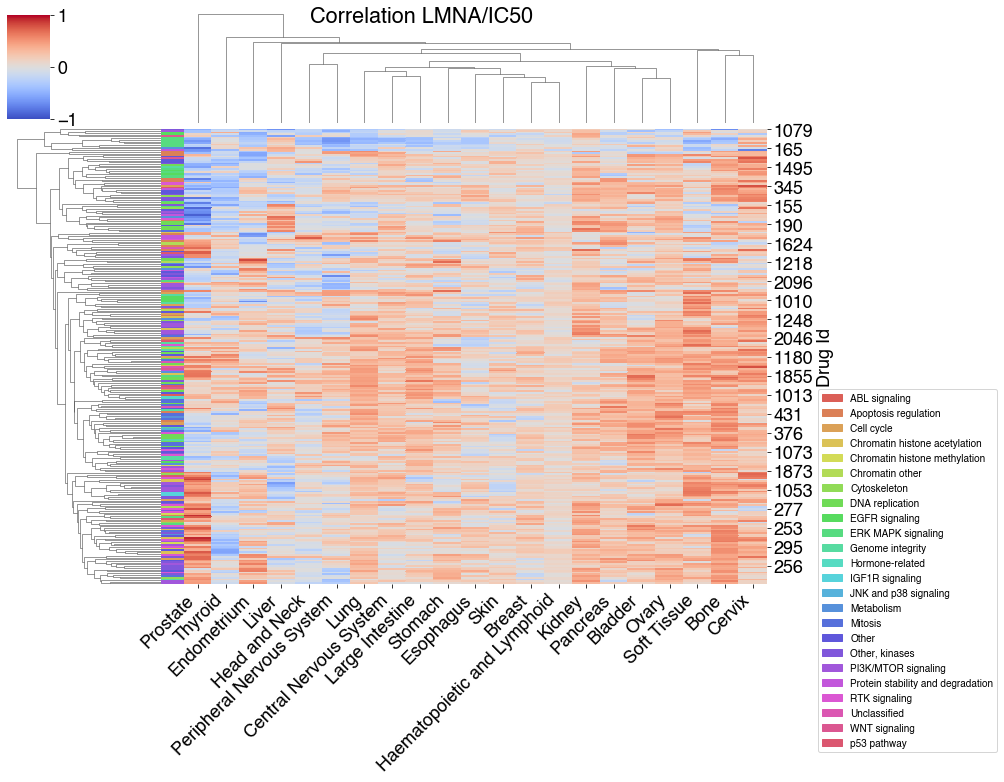

In [73]:
protein = 'LMNA_HUMAN'
heatmap(protein)

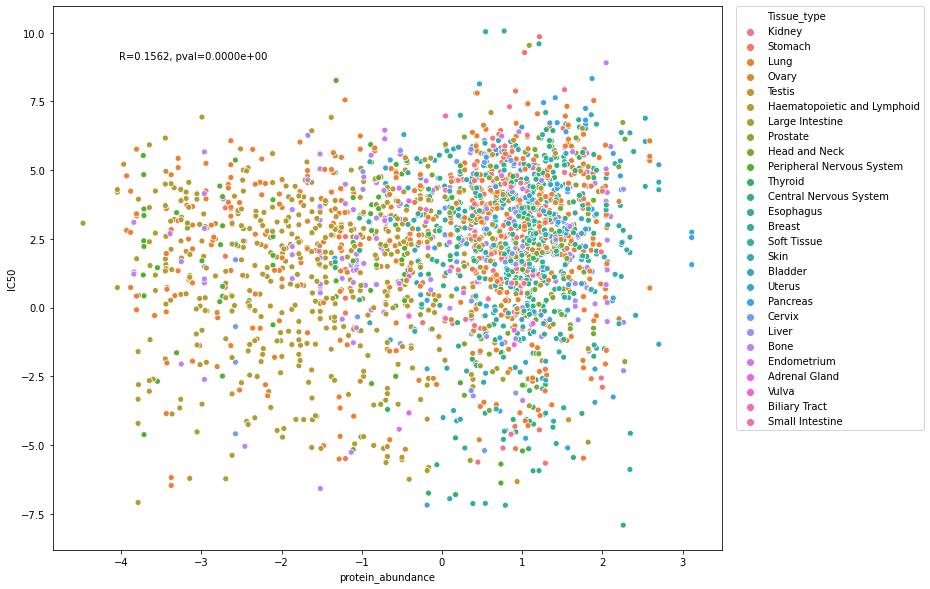

In [750]:
drug_scatter_all(protein)

(-0.7, 0.7)

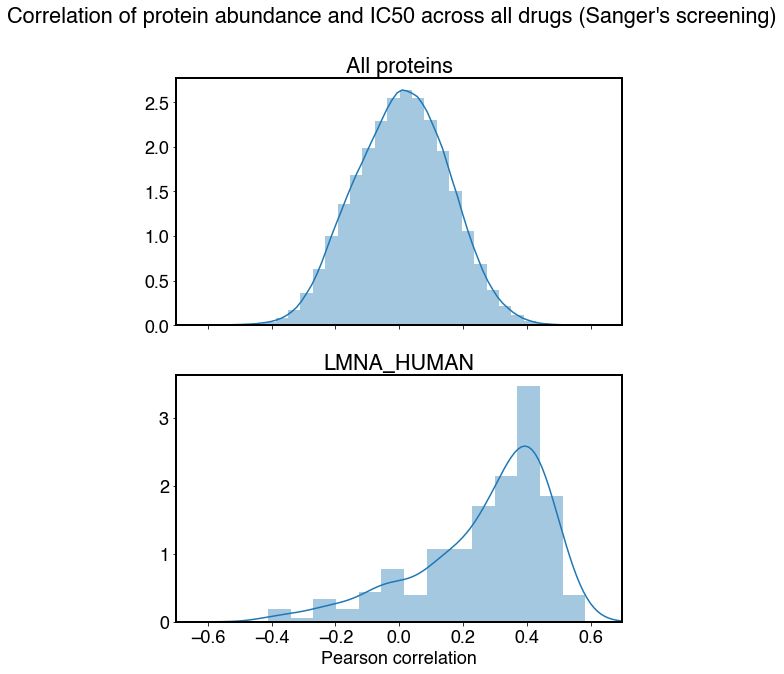

In [47]:
fig, ax = plt.subplots(2, 1, figsize=(8, 10), sharex=True)
fig.suptitle("Correlation of protein abundance and ln_IC50 across all drugs (Sanger's screening)")
sns.distplot(res_df_filtered['pearson_correlation'], ax=ax[0])
sns.distplot(res_df_filtered[res_df_filtered['protein'] ==
                                      'LMNA_HUMAN']['pearson_correlation'],
             ax=ax[1])
ax[0].set_title("All proteins")
ax[1].set_title("LMNA_HUMAN")
ax[0].set_xlabel("")
ax[1].set_xlabel("Pearson correlation")

plt.xlim(-0.7, 0.7)

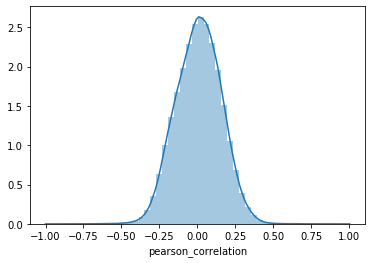

In [43]:
sns.distplot(res_df_filtered['pearson_correlation'])

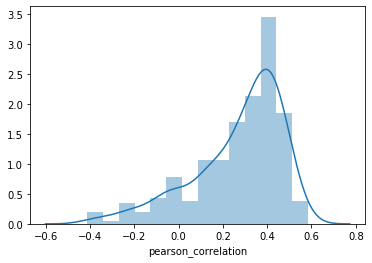

In [42]:
sns.distplot(res_df_filtered[res_df_filtered['protein']=='LMNA_HUMAN']['pearson_correlation'])

### K2C8

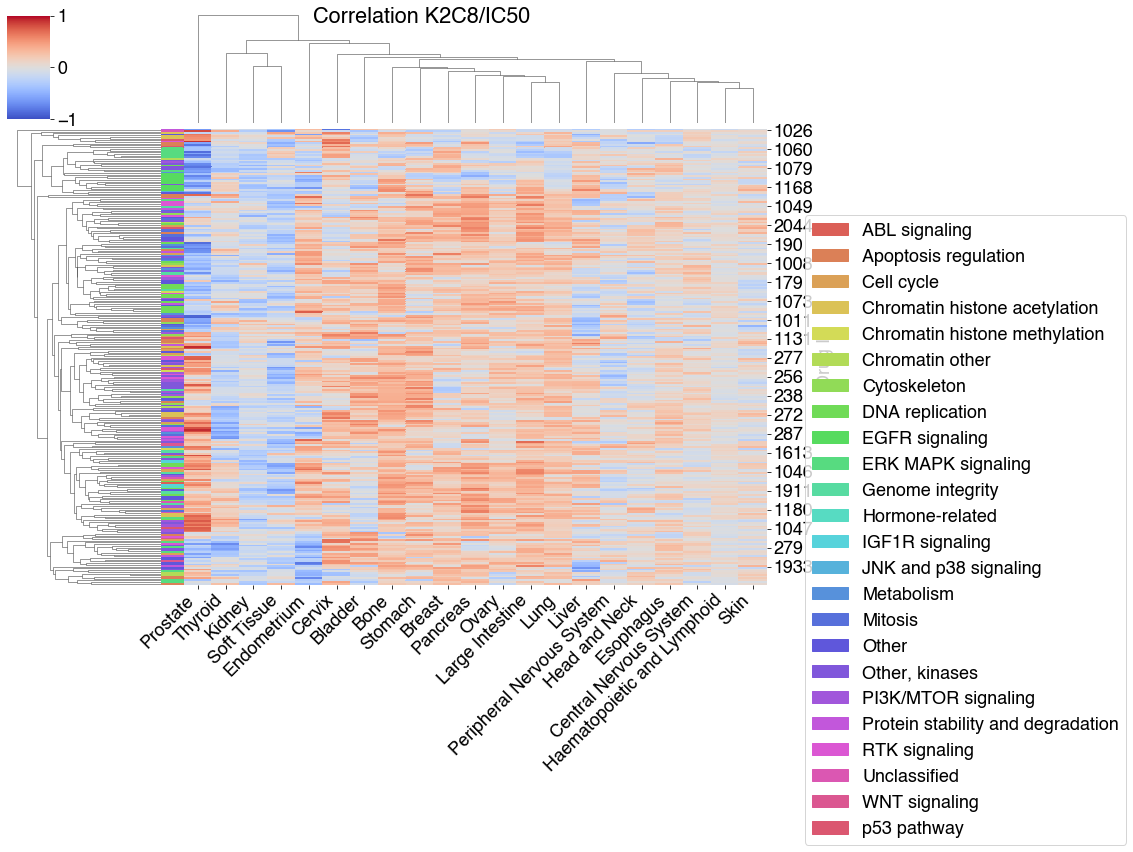

In [48]:
protein = 'K2C8_HUMAN'
heatmap(protein)

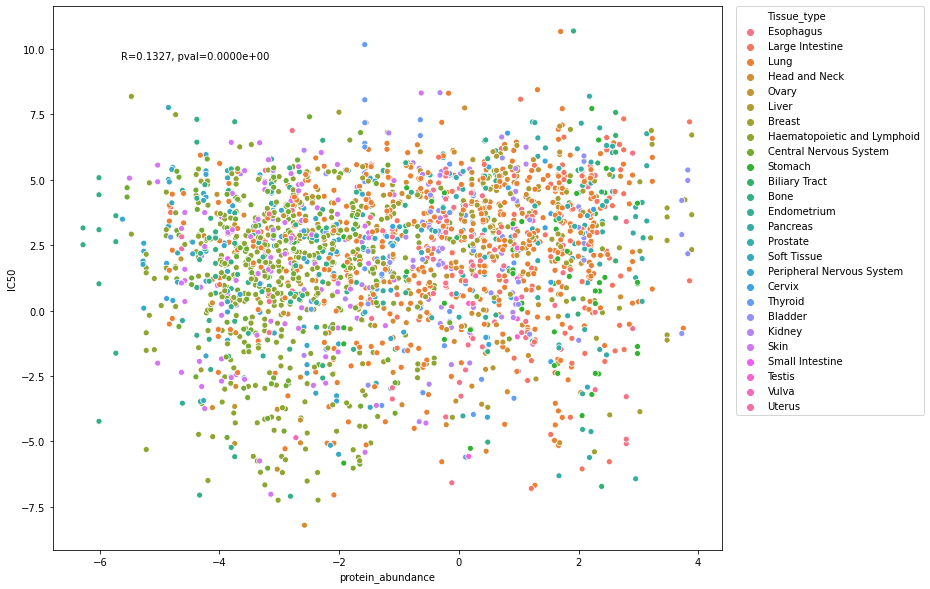

In [752]:
drug_scatter_all(protein)

(-0.7, 0.7)

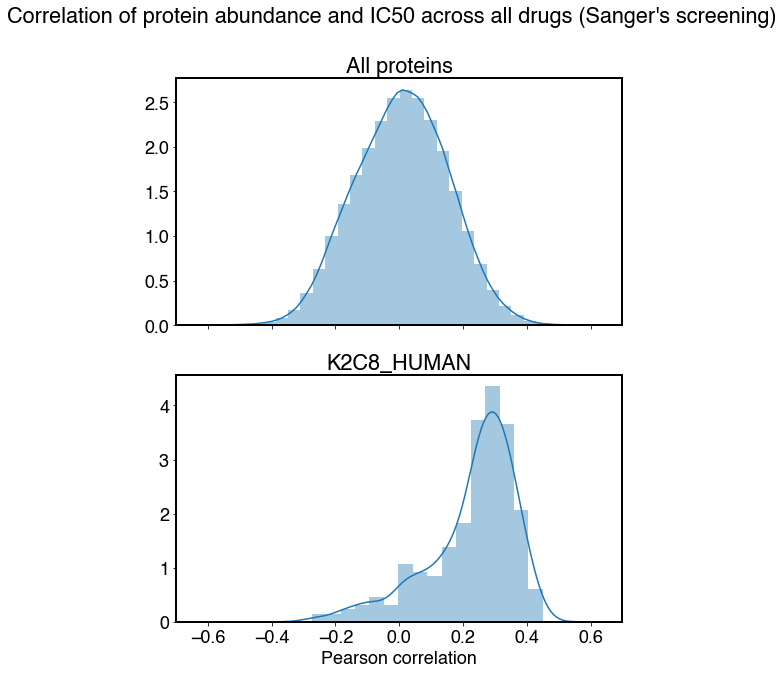

In [49]:
fig, ax = plt.subplots(2, 1, figsize=(8, 10), sharex=True)
fig.suptitle("Correlation of protein abundance and ln_IC50 across all drugs (Sanger's screening)")
sns.distplot(res_df_filtered['pearson_correlation'], ax=ax[0])
sns.distplot(res_df_filtered[res_df_filtered['protein'] ==
                                      protein]['pearson_correlation'],
             ax=ax[1])
ax[0].set_title("All proteins")
ax[1].set_title(protein)
ax[0].set_xlabel("")
ax[1].set_xlabel("Pearson correlation")

plt.xlim(-0.7, 0.7)

### MDR1

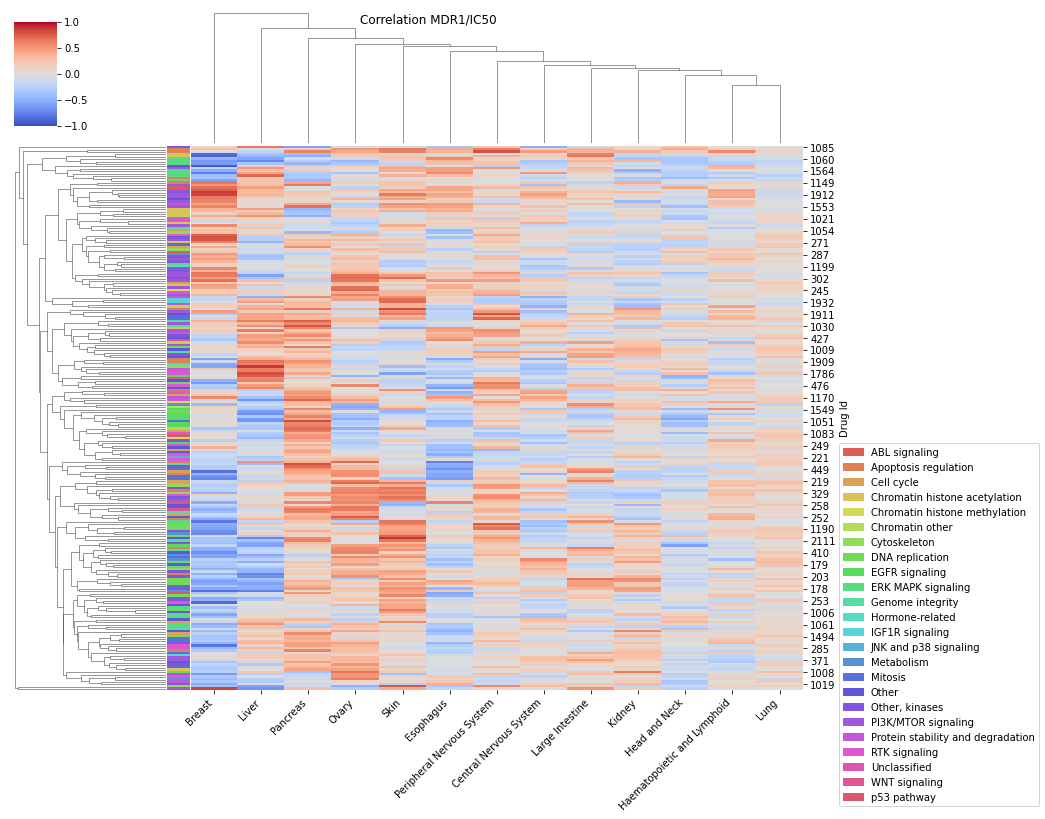

In [753]:
protein = 'MDR1_HUMAN'
heatmap(protein)

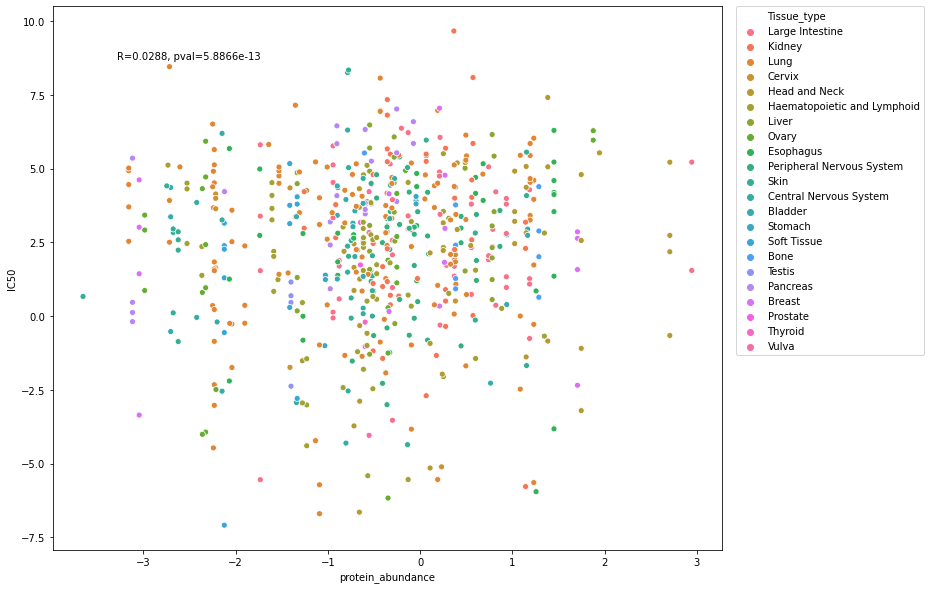

In [754]:
drug_scatter_all(protein)

### ERBB2

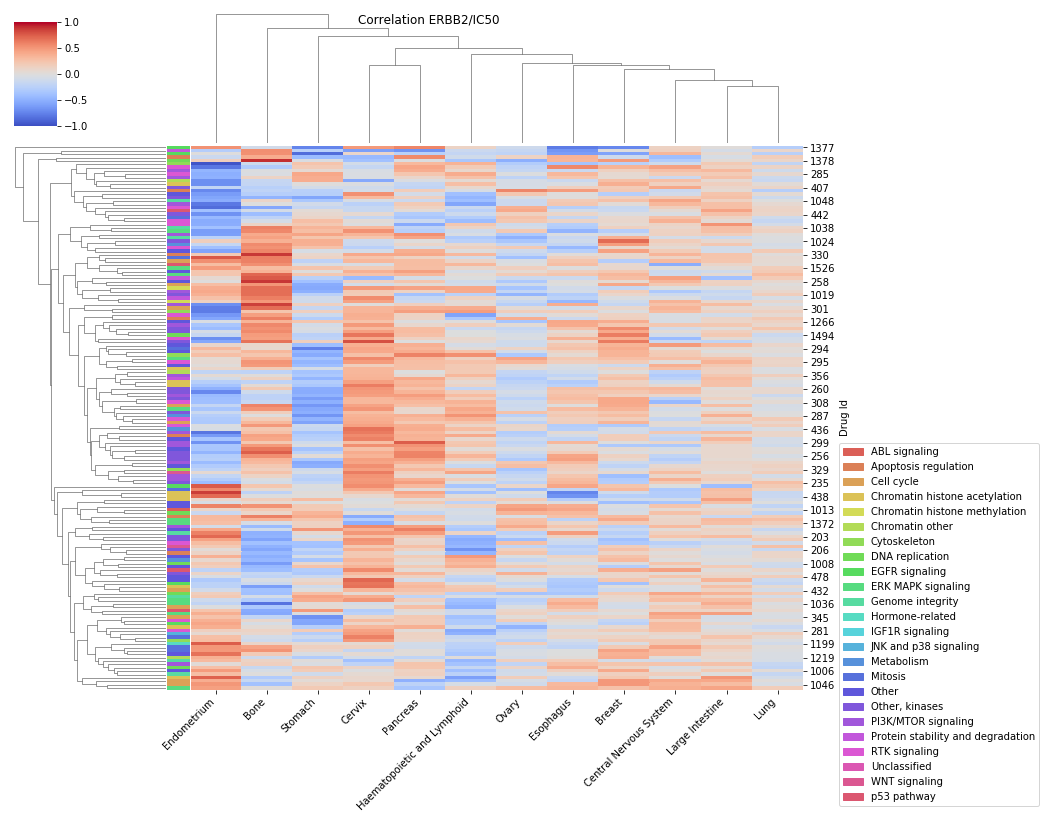

In [22]:
protein = 'ERBB2_HUMAN'
heatmap(protein)

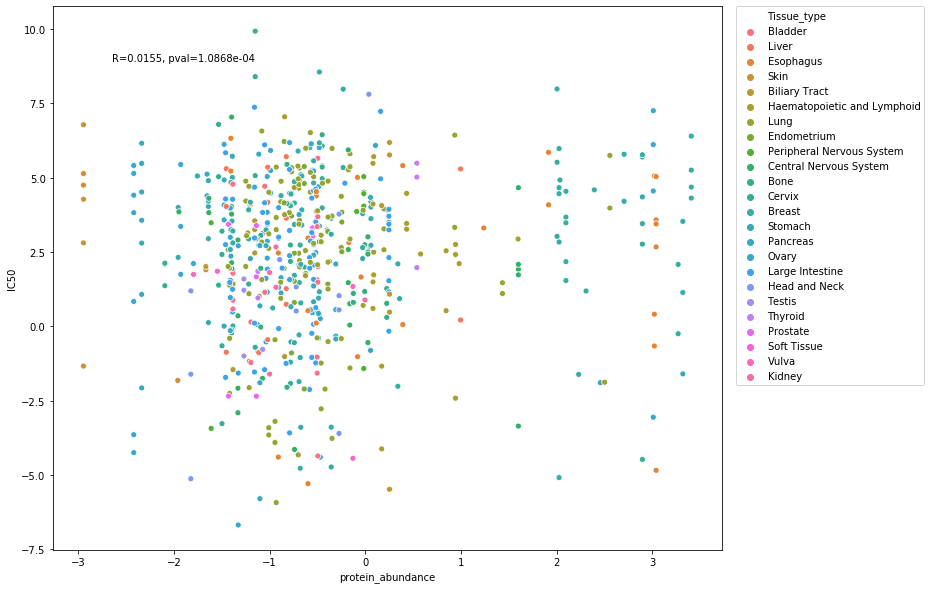

In [23]:
drug_scatter_all(protein)

/Users/scai/anaconda3/envs/sanger/lib/python3.8/site-packages/seaborn/matrix.py:1190: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 



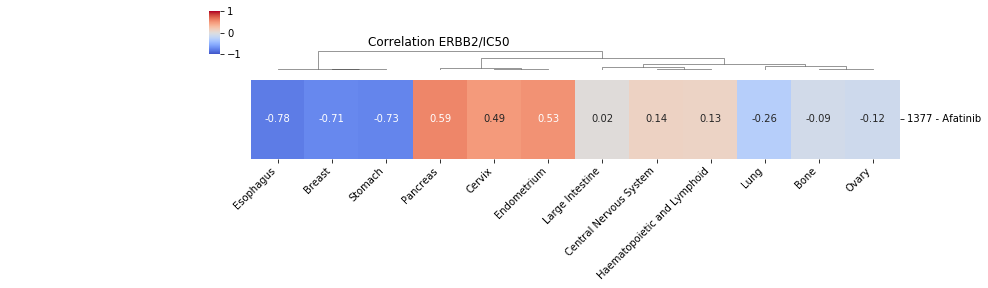

In [24]:
drug = 1377
heatmap_drug_one(protein, drug)

(-0.7, 0.7)

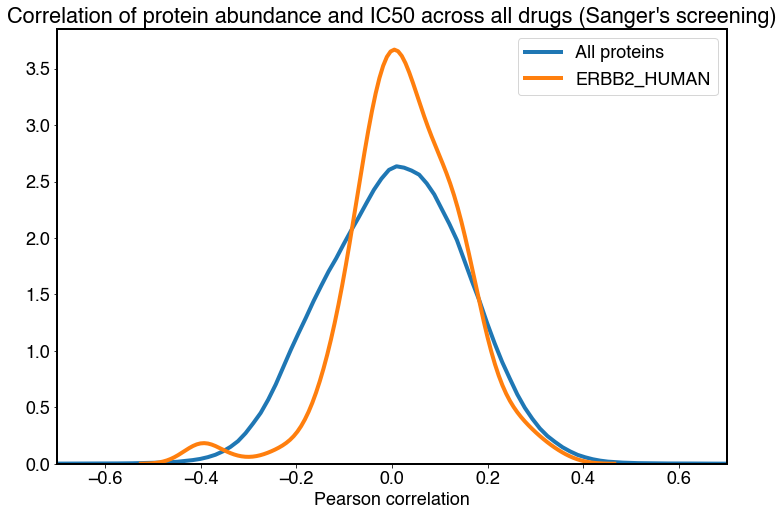

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8), sharex=True)
plt.title("Correlation of protein abundance and ln_IC50 across all drugs (Sanger's screening)")
sns.distplot(res_df_filtered['pearson_correlation'], label='All proteins', hist=False, kde_kws=dict(linewidth=4))
sns.distplot(res_df_filtered[res_df_filtered['protein'] ==
                                      "ERBB2_HUMAN"]['pearson_correlation'], label='ERBB2_HUMAN', hist=False, kde_kws=dict(linewidth=4))

plt.xlabel("Pearson correlation")
plt.xlim(-0.7, 0.7)

### MIEN1

In [516]:
protein = 'MIEN1_HUMAN'

In [517]:
res_all_filtered_protein = res_all_filtered[res_all_filtered['protein']==protein]
res_df_filtered_protein = res_df_filtered[res_df_filtered['protein']==protein]

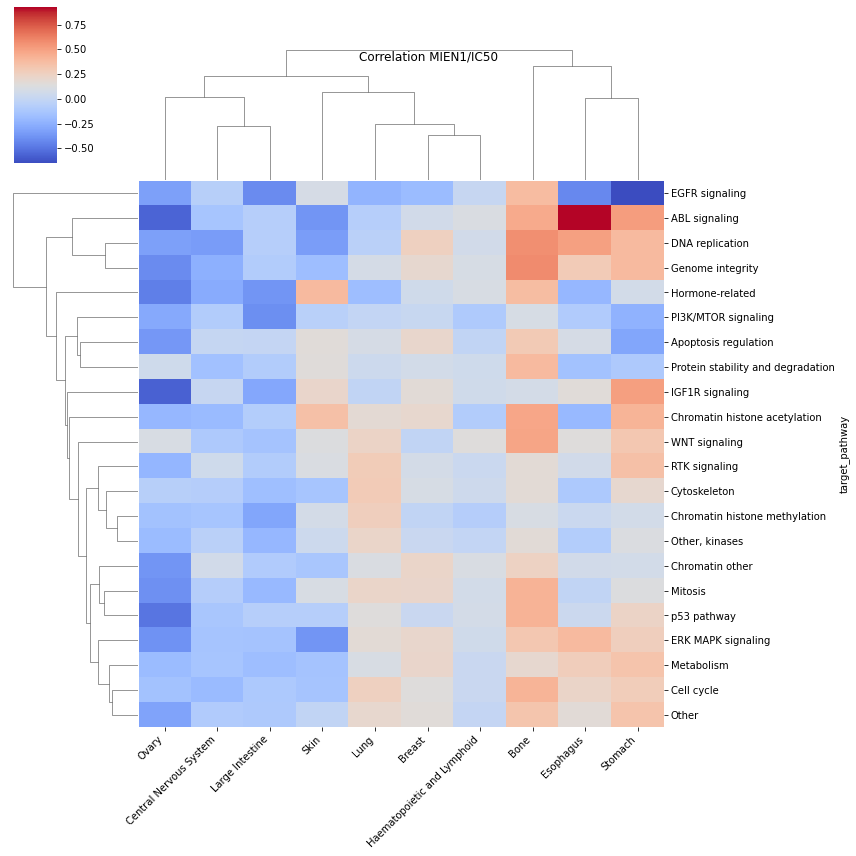

In [518]:
tmp_df = pd.pivot(res_all_filtered_protein.groupby([
    'tissue', 'target_pathway'
])['pearson_correlation'].mean().sort_values().reset_index(),
         index='target_pathway',
         columns='tissue')
tmp_df.columns = [x[1].replace('pearson_correlation-','') for x in tmp_df.columns]
tmp_df = tmp_df.dropna()
g = sns.clustermap(tmp_df, cmap='coolwarm', figsize=(12,12), cbar_pos=(0.02, 0.85, 0.05, 0.18))
protein = protein.replace('_HUMAN','')
g.fig.suptitle(f'Correlation {protein}/ln_IC50')
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.show()

Text(-2.5642021191889324, 9.698208333306312, 'R=0.0442, pval=1.6430e-23')

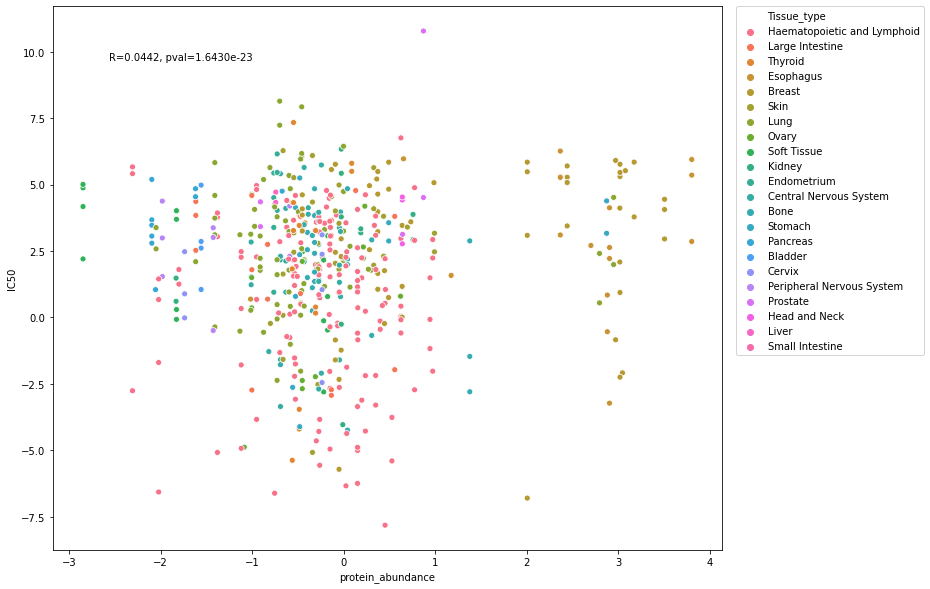

In [519]:
protein_map = protein_sample.set_index('Cell_line').to_dict()[f'{protein}_HUMAN']

tmp_ic50 = ic50[['drug_id', 'cell_line_name', 'ln_IC50','Tissue_type']]

tmp_ic50 = tmp_ic50[tmp_ic50['drug_id'].isin(drug_list)]

tmp_ic50['protein_abundance'] = tmp_ic50['cell_line_name'].map(protein_map)

plt.figure(figsize=(12,10))
tmp_ic50 = tmp_ic50.dropna()
r, pval = pearsonr(tmp_ic50['protein_abundance'], tmp_ic50['ln_IC50'])
tmp_ic50 = tmp_ic50.sample(frac=0.01)
sns.scatterplot(x='protein_abundance', y='ln_IC50', hue='Tissue_type', data=tmp_ic50)
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.text(tmp_ic50['protein_abundance'].min()*0.9, tmp_ic50['ln_IC50'].max()*0.9, f'R={r:.4f}, pval={pval:.4e}')

### EGFR

In [520]:
protein = 'EGFR_HUMAN'

In [521]:
res_all_filtered_protein = res_all_filtered[res_all_filtered['protein']==protein]
res_df_filtered_protein = res_df_filtered[res_df_filtered['protein']==protein]

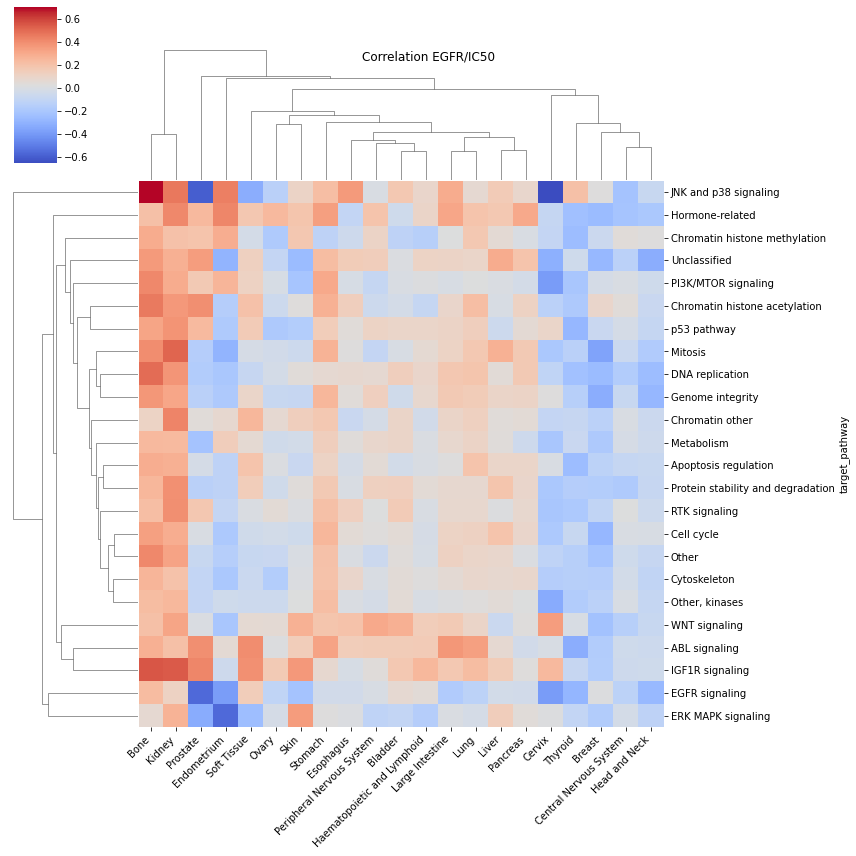

In [522]:
tmp_df = pd.pivot(res_all_filtered_protein.groupby([
    'tissue', 'target_pathway'
])['pearson_correlation'].mean().sort_values().reset_index(),
         index='target_pathway',
         columns='tissue')
tmp_df.columns = [x[1].replace('pearson_correlation-','') for x in tmp_df.columns]
g = sns.clustermap(tmp_df, cmap='coolwarm', figsize=(12,12), cbar_pos=(0.02, 0.85, 0.05, 0.18))
protein = protein.replace('_HUMAN','')
g.fig.suptitle(f'Correlation {protein}/ln_IC50')
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.show()

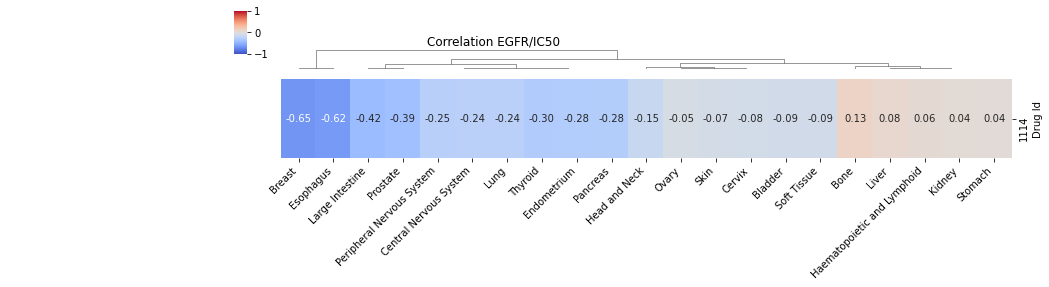

In [523]:
drug = 1114
res_all_filtered_protein_drug = res_all_filtered_protein[
    res_all_filtered_protein['drug_id'] == drug]
tmp_df = pd.pivot(res_all_filtered_protein_drug.groupby(
    ['tissue',
     'drug_id'])['pearson_correlation'].mean().sort_values().reset_index(),
                  index='drug_id',
                  columns='tissue')
tmp_df.columns = [
    x[1].replace('pearson_correlation-', '') for x in tmp_df.columns
]
g = sns.clustermap(tmp_df,
                   cmap='coolwarm',
                   figsize=(18, 2),
                   cbar_pos=(0.3, 0.85, 0.01, 0.3),
                   vmin=-1,
                   vmax=1,
                   row_cluster=False, annot=True, fmt='.2f')
protein = protein.replace('_HUMAN', '')
g.fig.suptitle(f'Correlation {protein}/ln_IC50')
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.show()

Text(-4.621690227672107, 9.358190223797603, 'R=0.0324, pval=2.6419e-39')

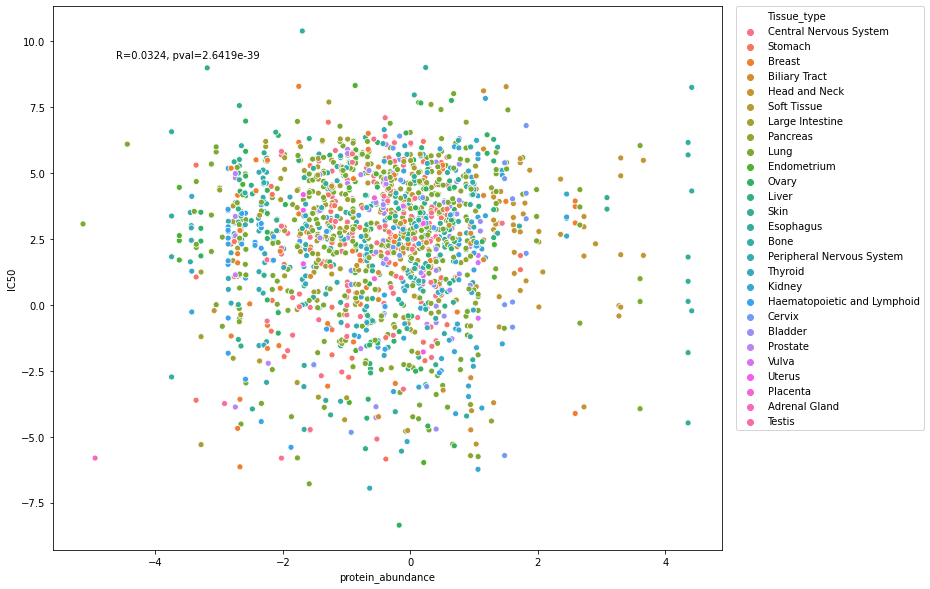

In [524]:
protein_map = protein_sample.set_index('Cell_line').to_dict()[f'{protein}_HUMAN']

tmp_ic50 = ic50[['drug_id', 'cell_line_name', 'ln_IC50','Tissue_type']]

tmp_ic50 = tmp_ic50[tmp_ic50['drug_id'].isin(drug_list)]

tmp_ic50['protein_abundance'] = tmp_ic50['cell_line_name'].map(protein_map)

plt.figure(figsize=(12,10))
tmp_ic50 = tmp_ic50.dropna()
r, pval = pearsonr(tmp_ic50['protein_abundance'], tmp_ic50['ln_IC50'])
tmp_ic50 = tmp_ic50.sample(frac=0.01)
sns.scatterplot(x='protein_abundance', y='ln_IC50', hue='Tissue_type', data=tmp_ic50)
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.text(tmp_ic50['protein_abundance'].min()*0.9, tmp_ic50['ln_IC50'].max()*0.9, f'R={r:.4f}, pval={pval:.4e}')

### LSP1

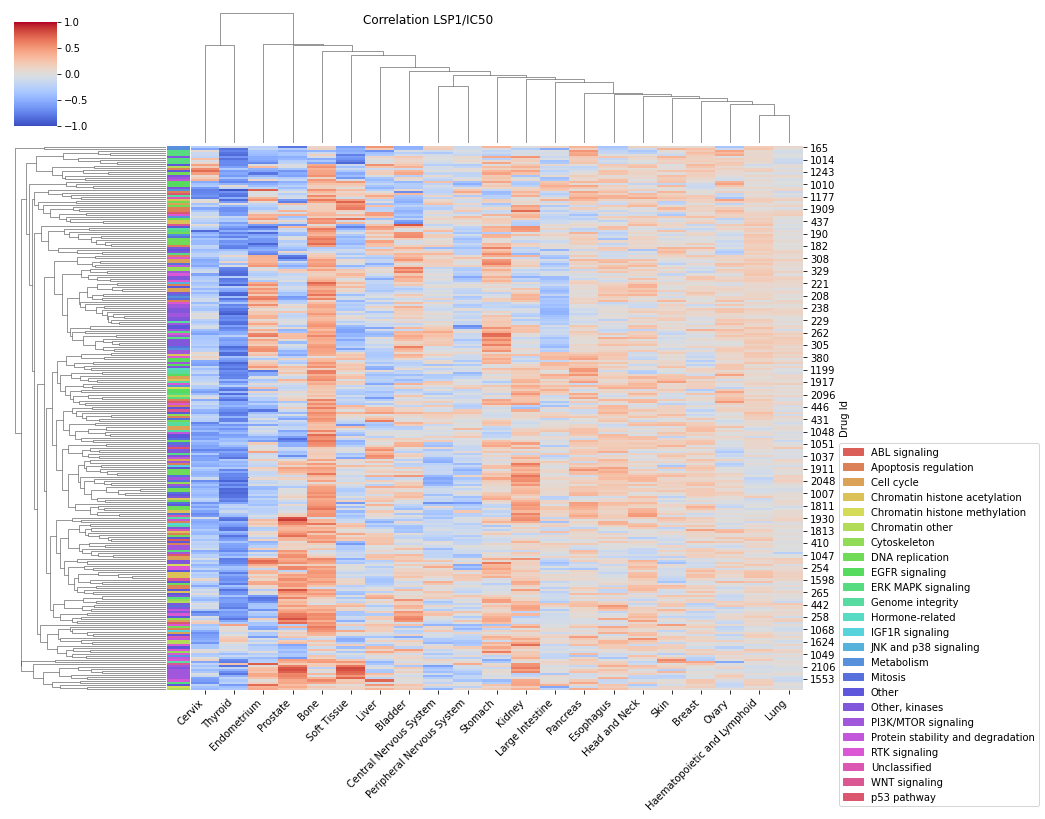

In [489]:
protein = 'LSP1_HUMAN'
drug = 271
heatmap(protein)

/Users/scai/anaconda3/envs/sklearn22/lib/python3.6/site-packages/seaborn/matrix.py:1165: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 



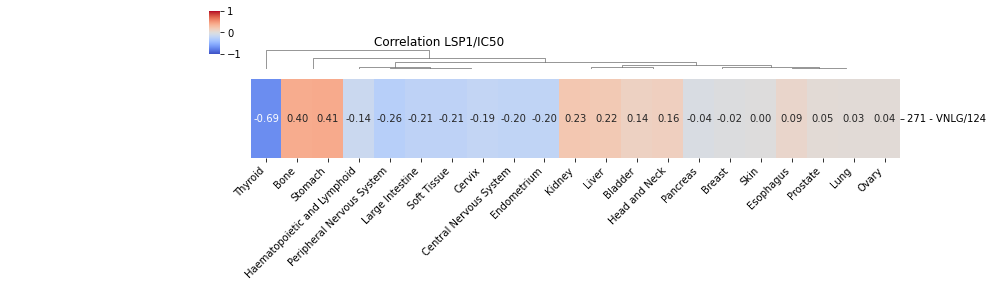

In [490]:
heatmap_drug_one(protein, drug)

/Users/scai/anaconda3/envs/sklearn22/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



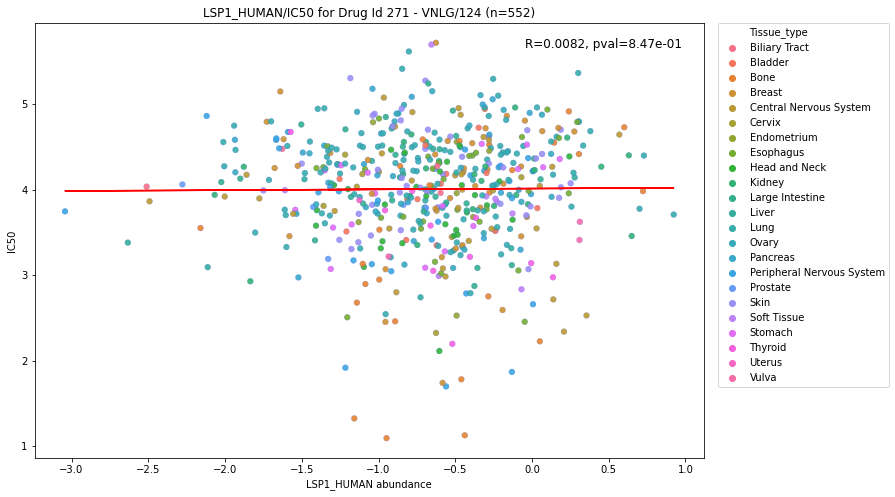

In [504]:
drug_scatter_one(protein, drug, protein_sample, ic50_noblood, x=0.85, y=0.95)

/Users/scai/anaconda3/envs/sklearn22/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



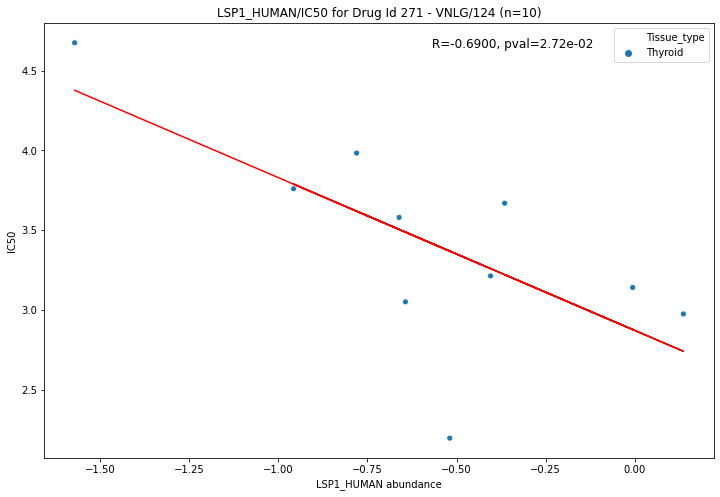

In [505]:
drug_scatter_one_tissue(protein,
                        drug,
                        protein_sample, ['Thyroid'],
                        x=0.7,
                        y=0.95)

### ABCF2

In [506]:
protein = 'ABCF2_HUMAN'
drug = 94

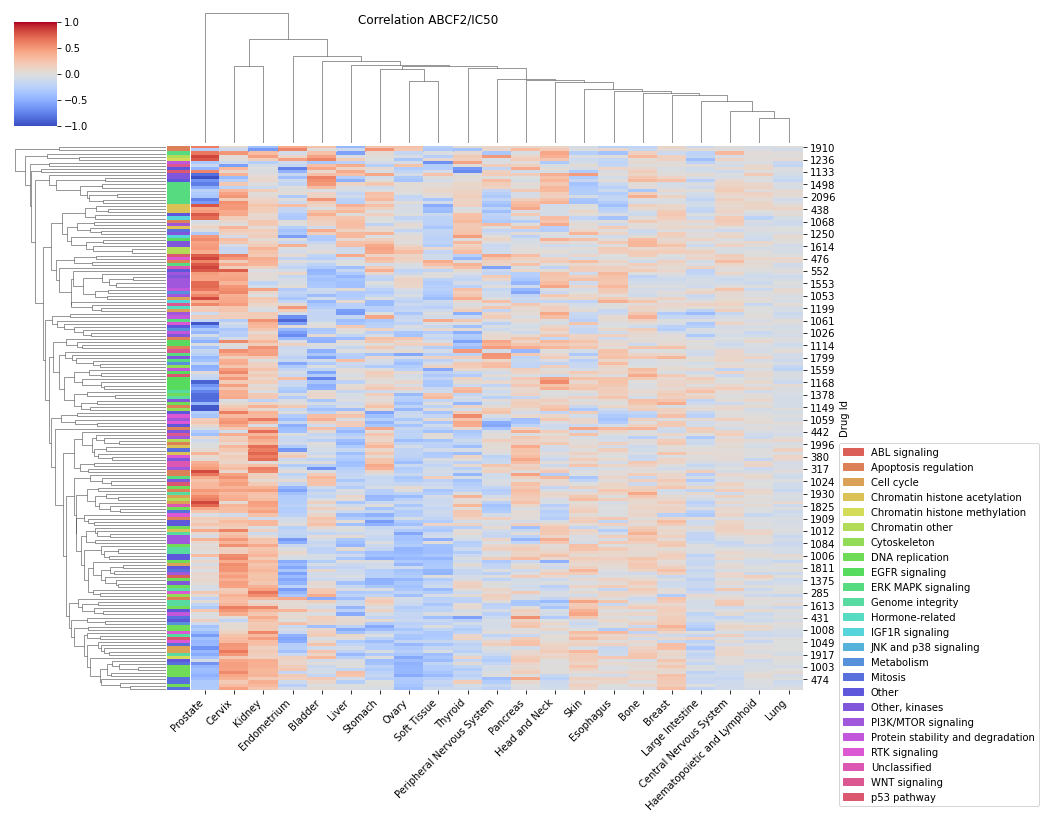

In [771]:
heatmap(protein)

/Users/scai/anaconda3/envs/sklearn22/lib/python3.6/site-packages/seaborn/matrix.py:1165: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 



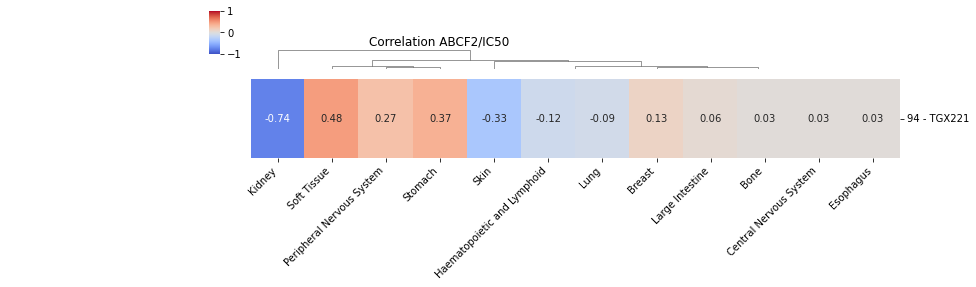

In [772]:
heatmap_drug_one(protein, drug)

/Users/scai/anaconda3/envs/sklearn22/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



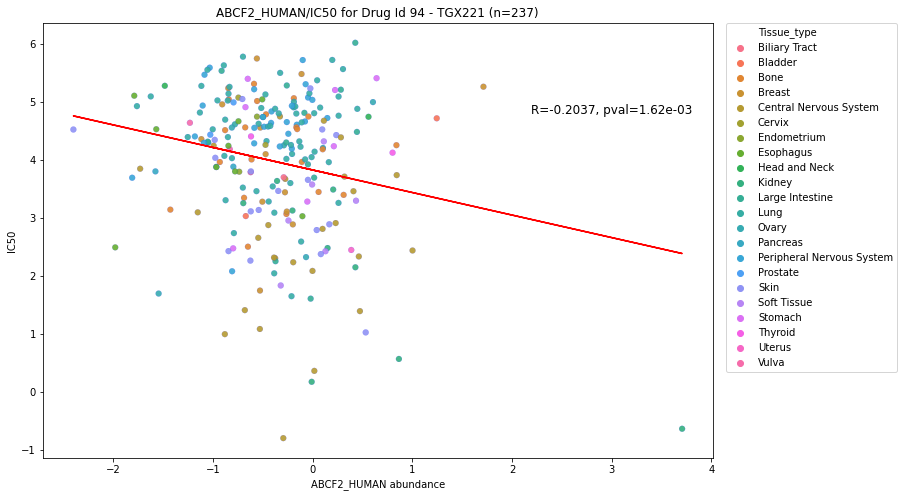

In [509]:
drug_scatter_one(protein, drug, protein_sample, ic50_noblood, x=0.85)

/Users/scai/anaconda3/envs/sklearn22/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



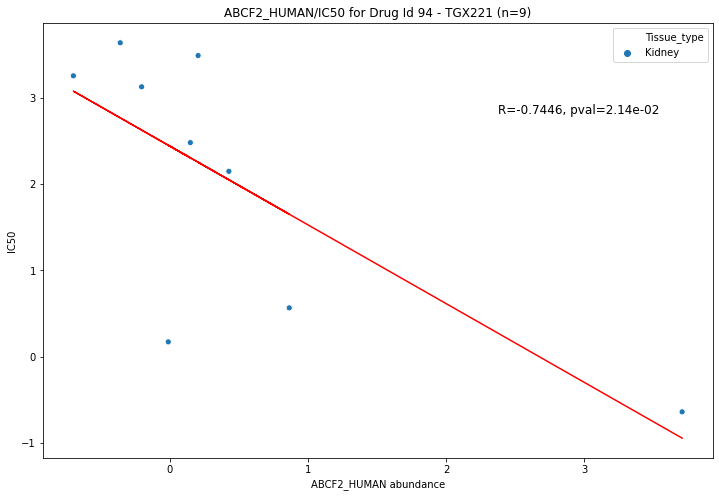

In [510]:
drug_scatter_one_tissue(protein, drug, protein_sample, ['Kidney'])

### TMM33

In [511]:
protein = 'TMM33_HUMAN'
drug = 552

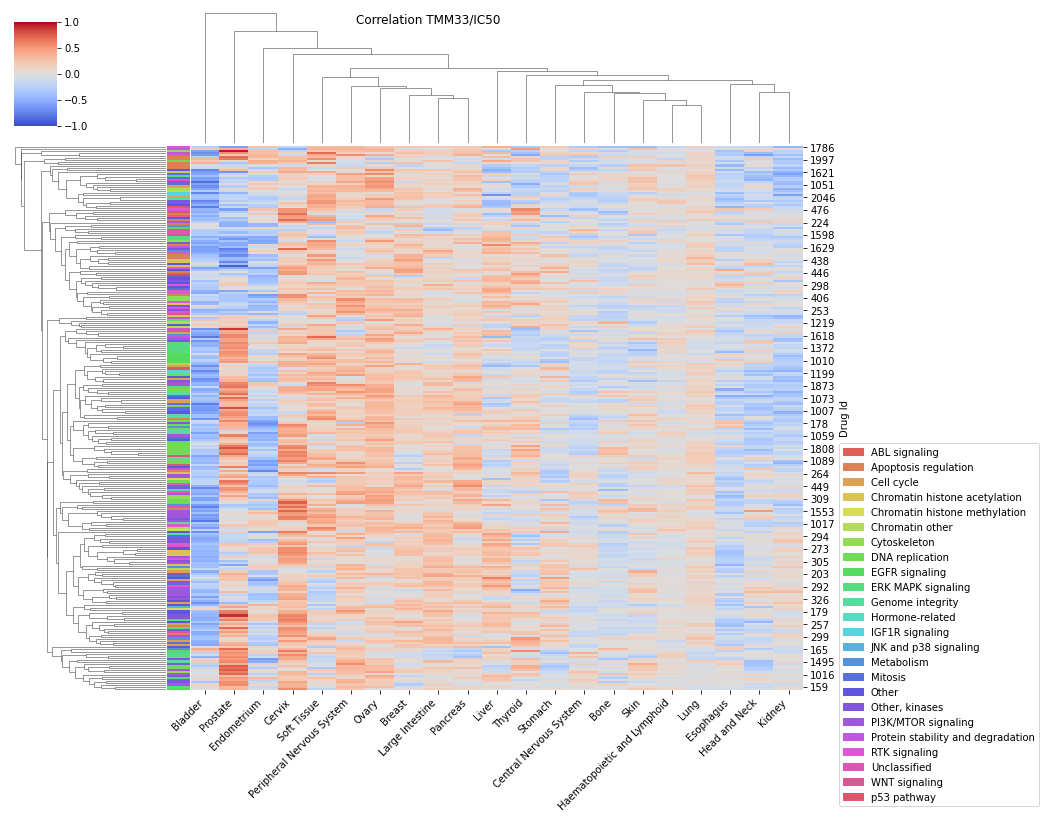

In [807]:
heatmap(protein)

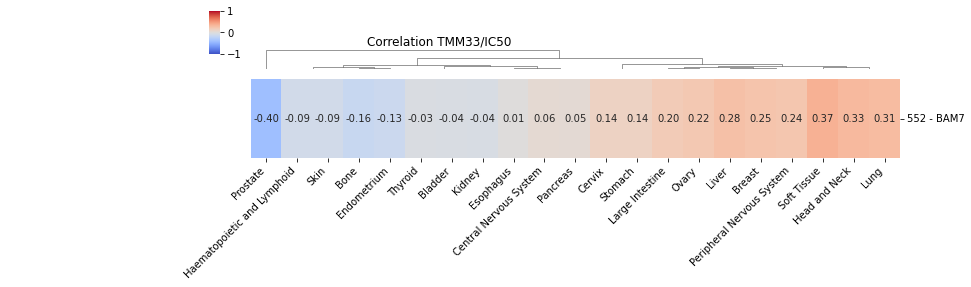

In [809]:
heatmap_drug_one(protein, drug)

/Users/scai/anaconda3/envs/sklearn22/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



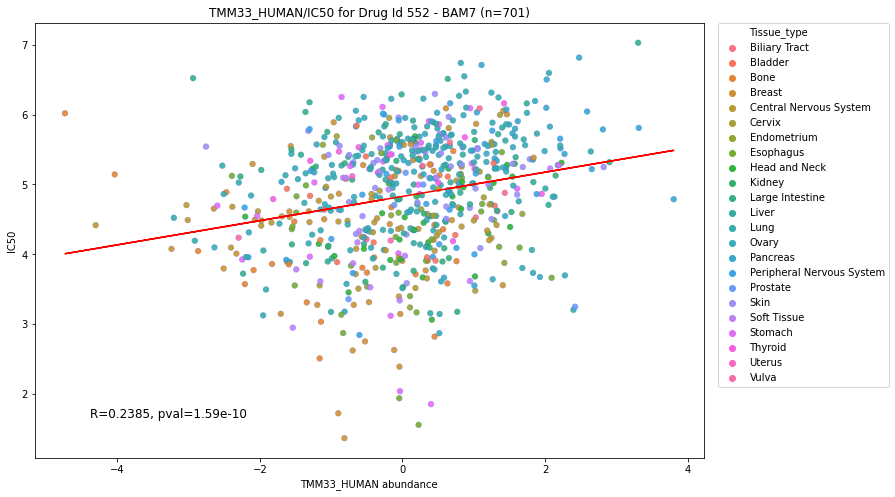

In [514]:
drug_scatter_one(protein, drug, protein_sample, ic50_noblood, x=0.2,y=0.1)

/Users/scai/anaconda3/envs/sklearn22/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



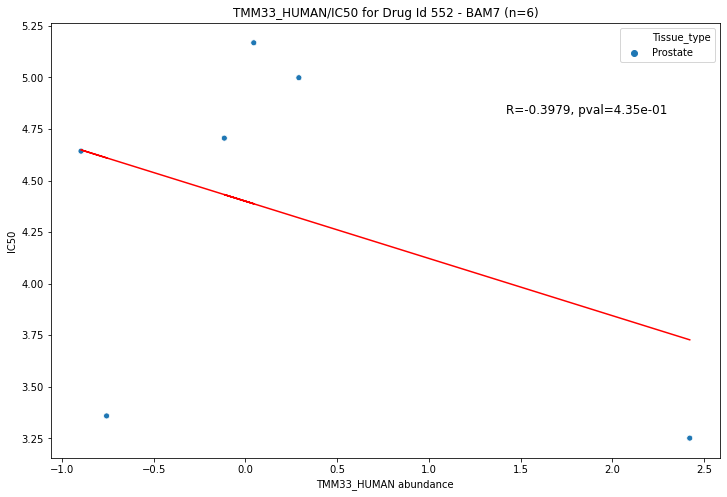

In [517]:
drug_scatter_one_tissue(protein, drug, protein_sample, ['Prostate'])

### TIMP1

In [519]:
protein = 'TIMP1_HUMAN'
drug = 281

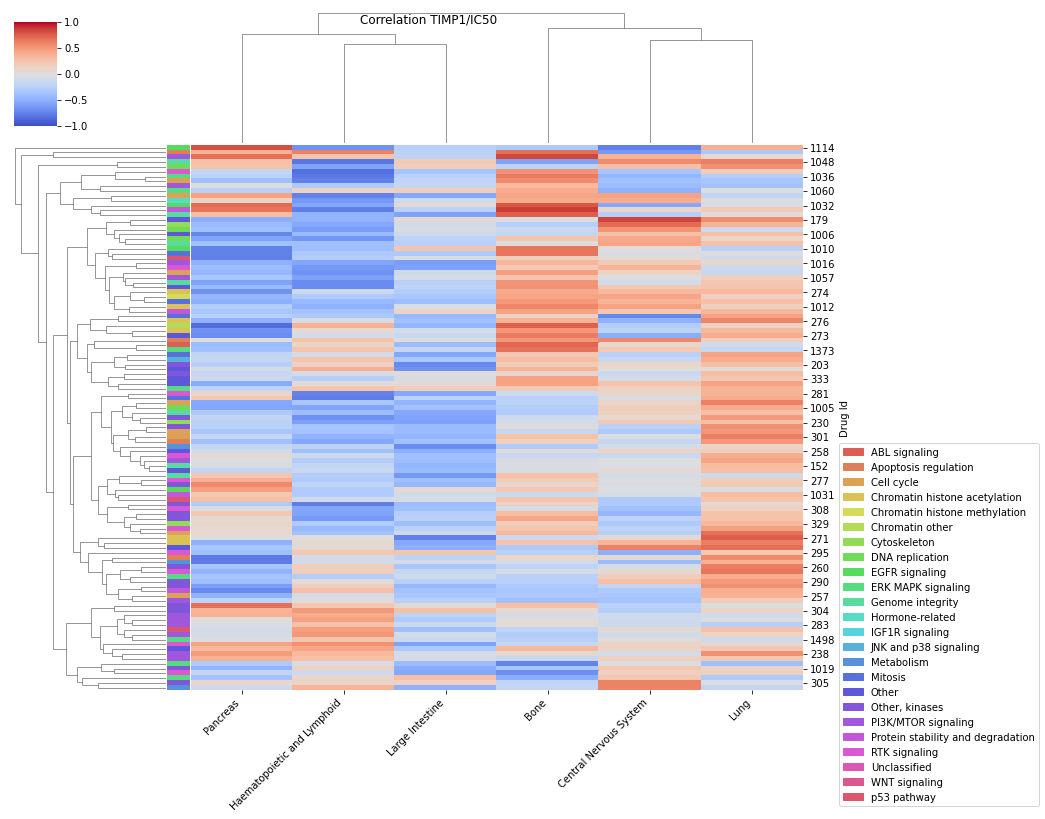

In [815]:
heatmap(protein)

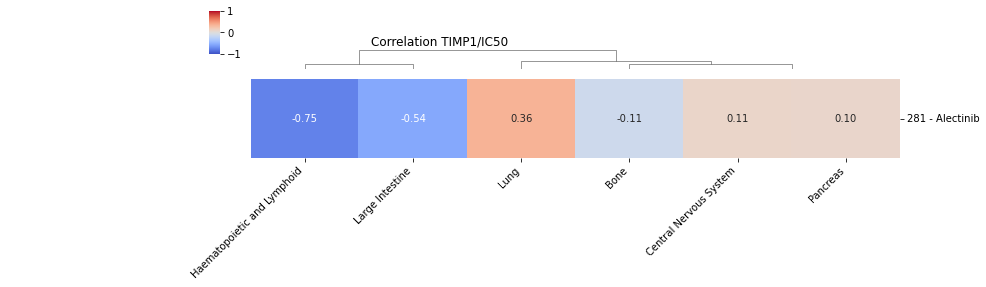

In [816]:
heatmap_drug_one(protein, drug)

/Users/scai/anaconda3/envs/sklearn22/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



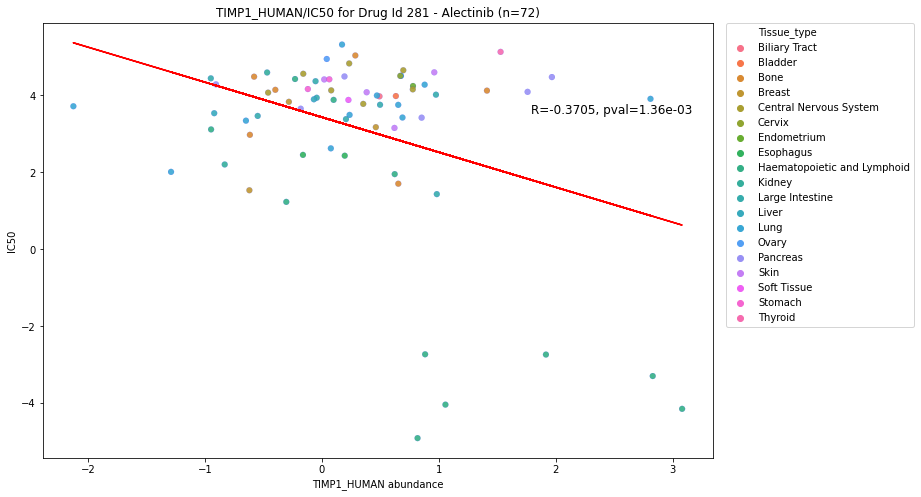

In [522]:
drug_scatter_one(protein, drug, protein_sample, ic50, x=0.85)

/Users/scai/anaconda3/envs/sklearn22/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



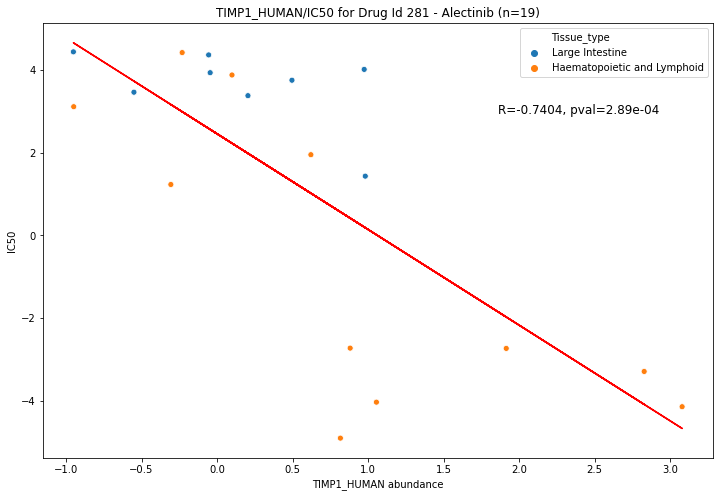

In [521]:
drug_scatter_one_tissue(protein, drug, protein_sample, ['Haematopoietic and Lymphoid', 'Large Intestine'])

### NAMPT

In [523]:
protein = 'NAMPT_HUMAN'
drug = 1248

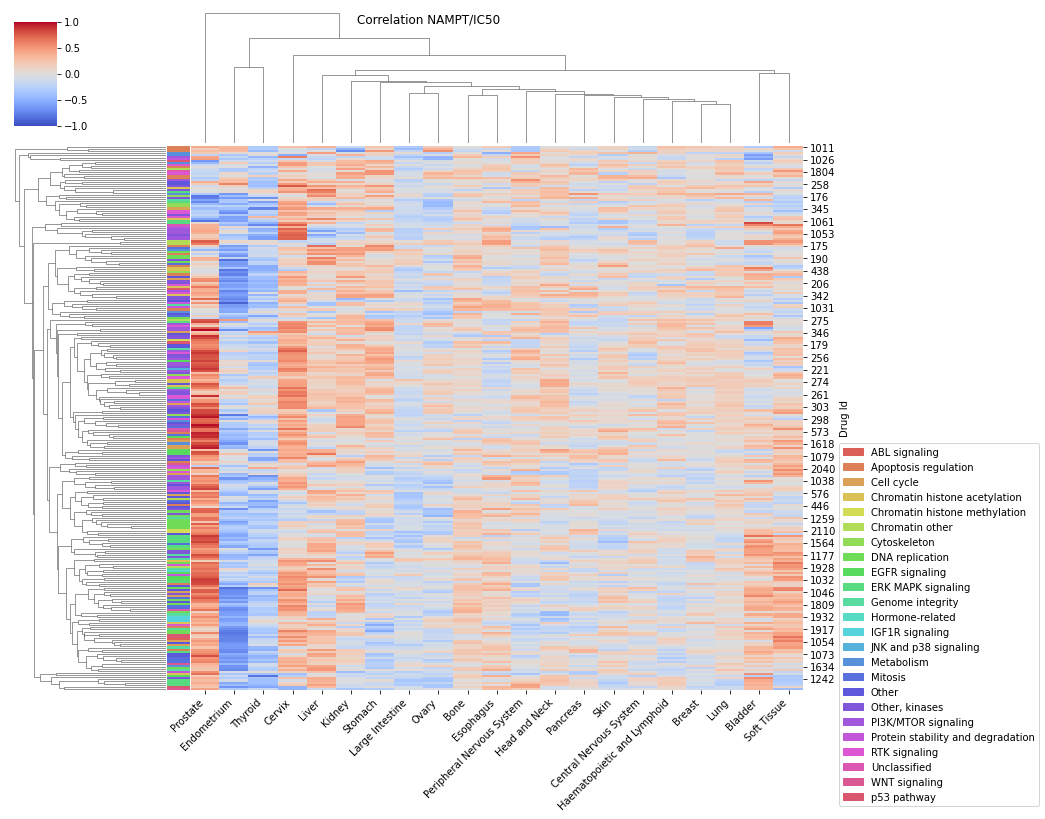

In [820]:
heatmap(protein)

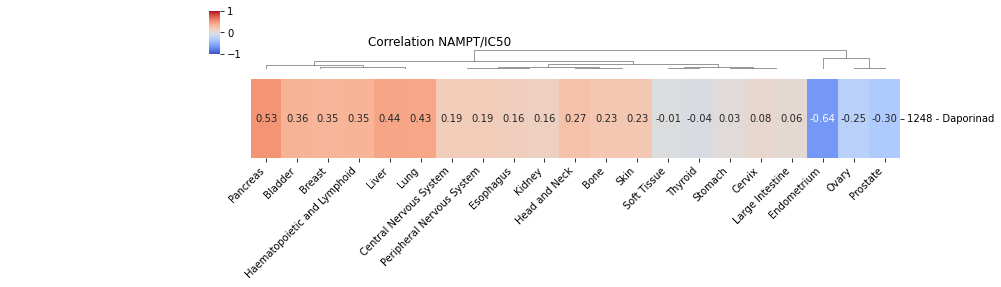

In [821]:
heatmap_drug_one(protein, drug)


/Users/scai/anaconda3/envs/sklearn22/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



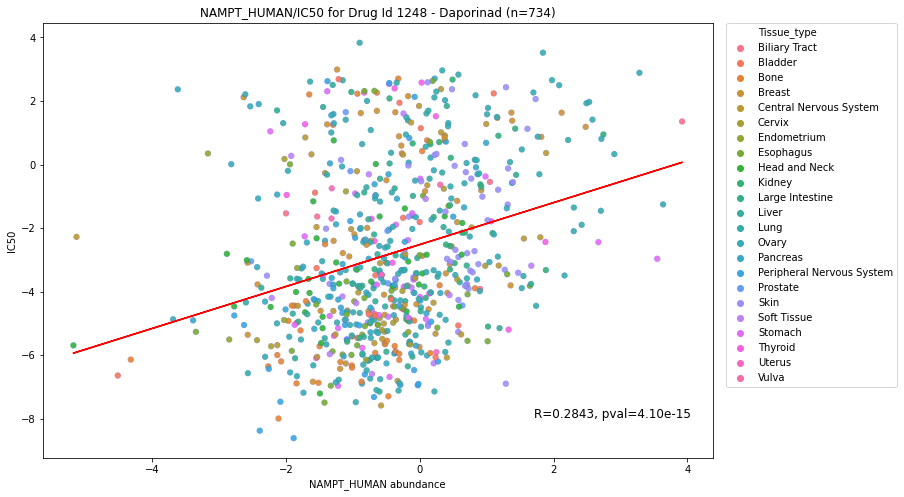

In [524]:
drug_scatter_one(protein, drug, protein_sample, ic50_noblood, x=0.85, y=0.1)

/Users/scai/anaconda3/envs/sklearn22/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



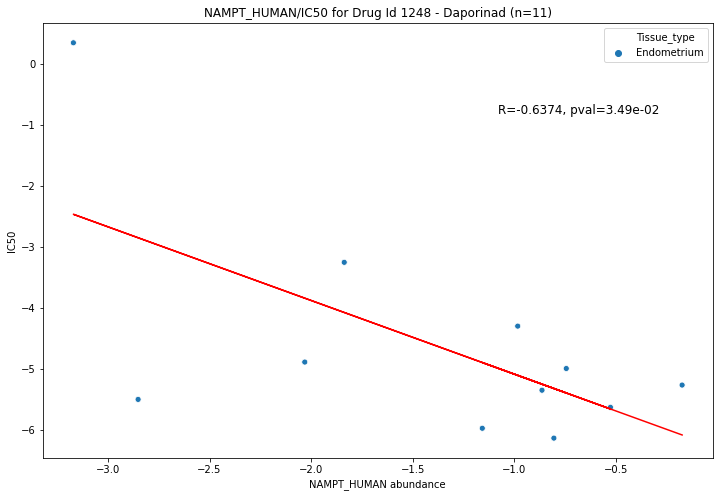

In [526]:
drug_scatter_one_tissue(protein, drug, protein_sample, ['Endometrium'])

### NNRD

In [528]:
protein = 'NNRD_HUMAN'
drug = 1266

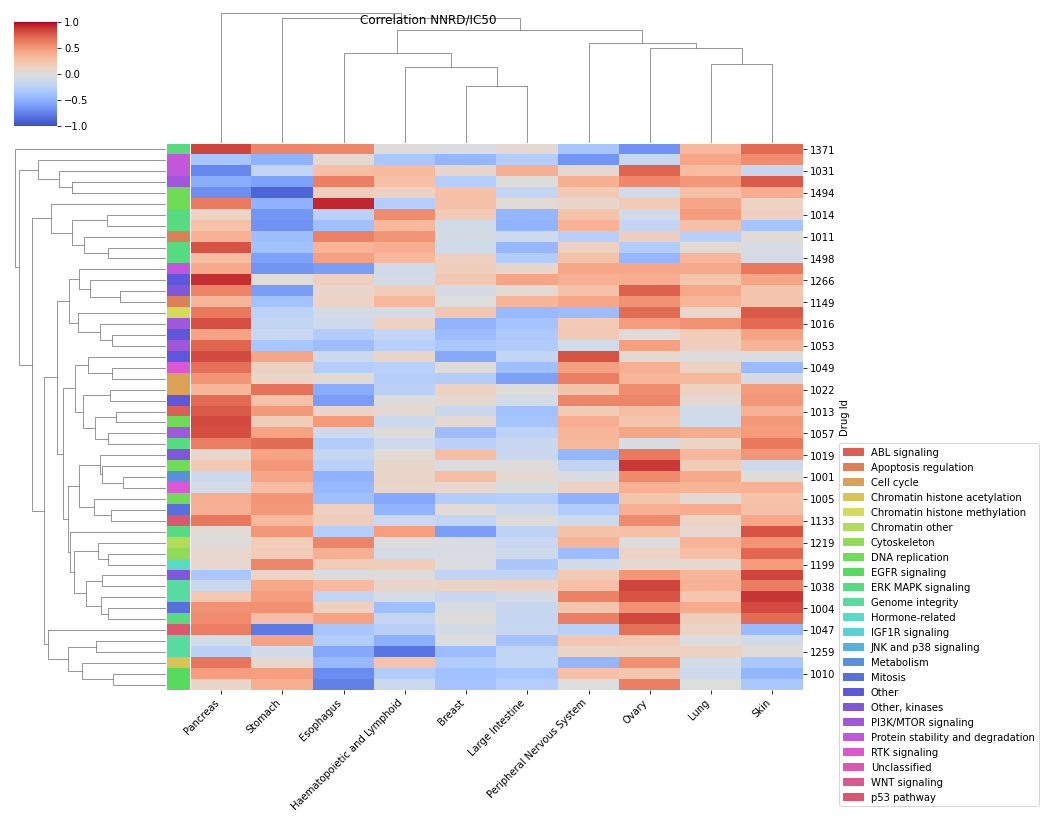

In [832]:
heatmap(protein)

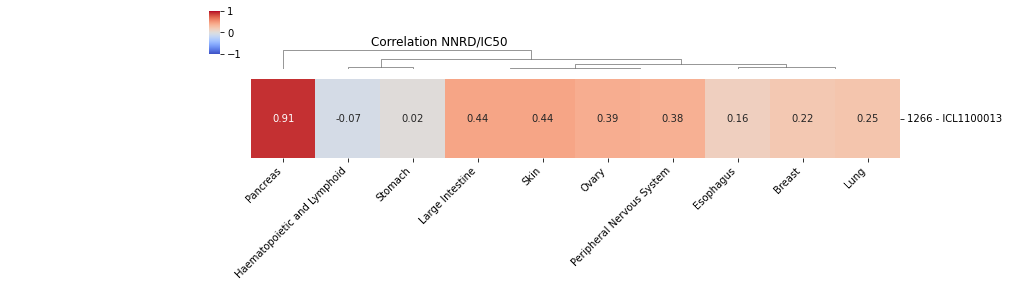

In [833]:
heatmap_drug_one(protein, drug)

/Users/scai/anaconda3/envs/sklearn22/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



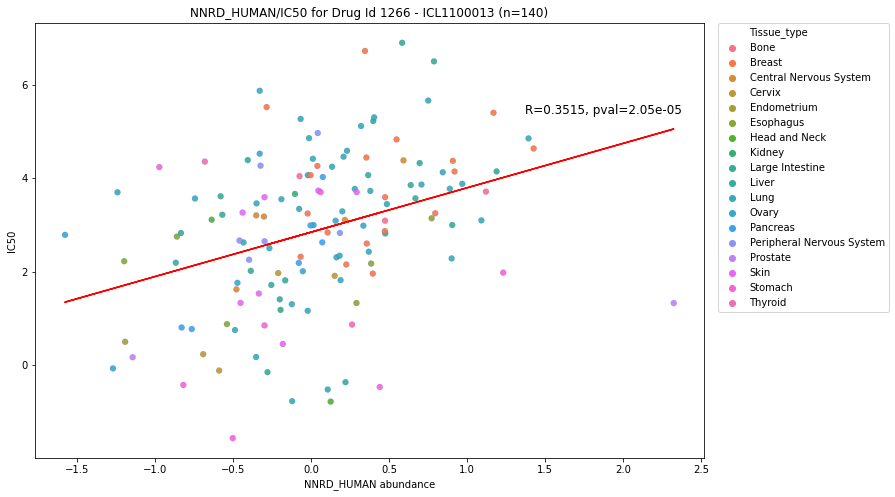

In [529]:
drug_scatter_one(protein, drug, protein_sample, ic50_noblood, x=0.85)

/Users/scai/anaconda3/envs/sklearn22/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



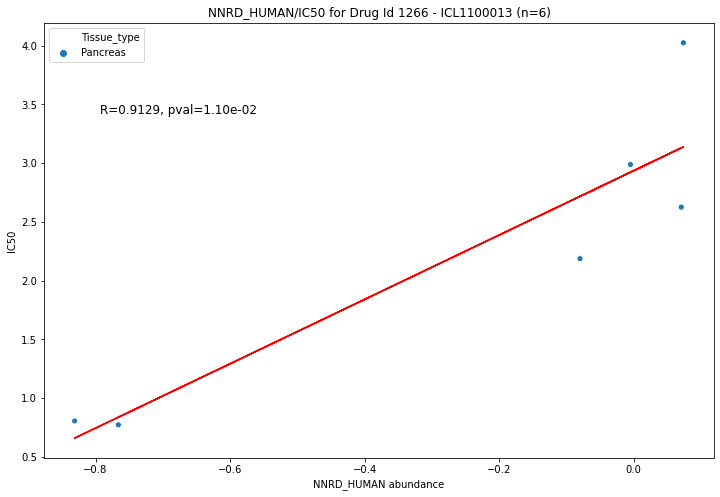

In [530]:
drug_scatter_one_tissue(protein, drug, protein_sample, ['Pancreas'], x=0.2)

### 4F2_HUMAN

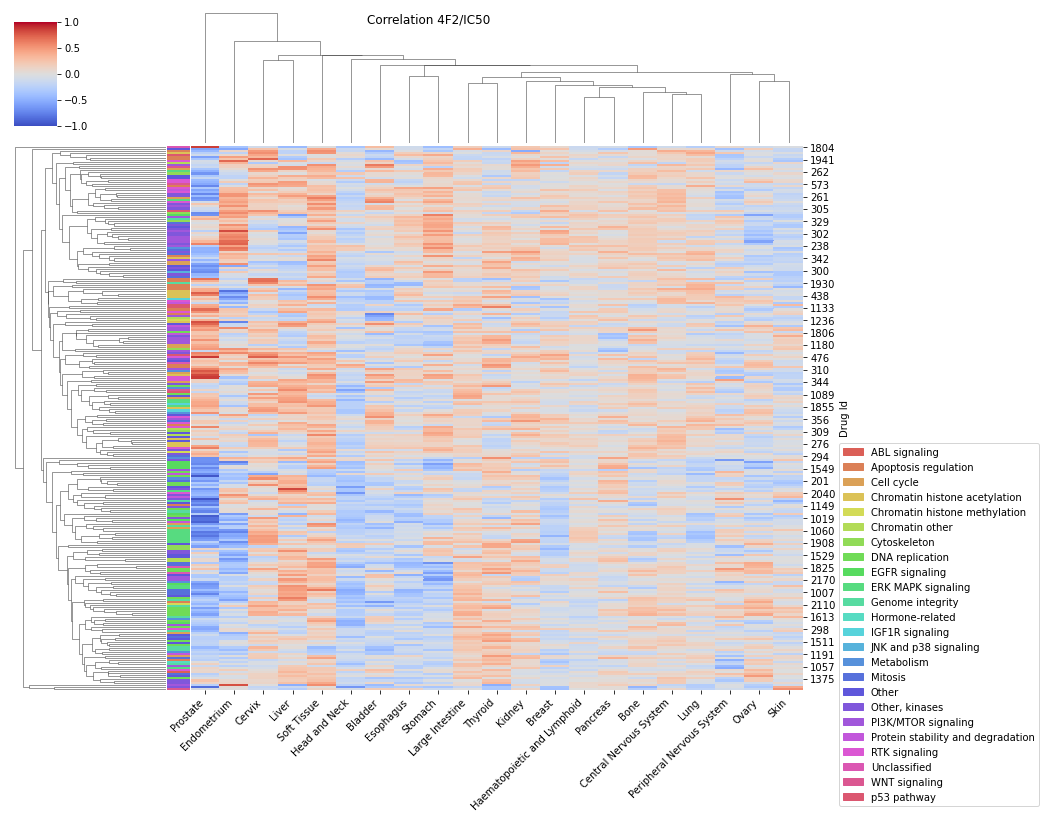

In [842]:
protein = '4F2_HUMAN'
drug = 1377
heatmap(protein)

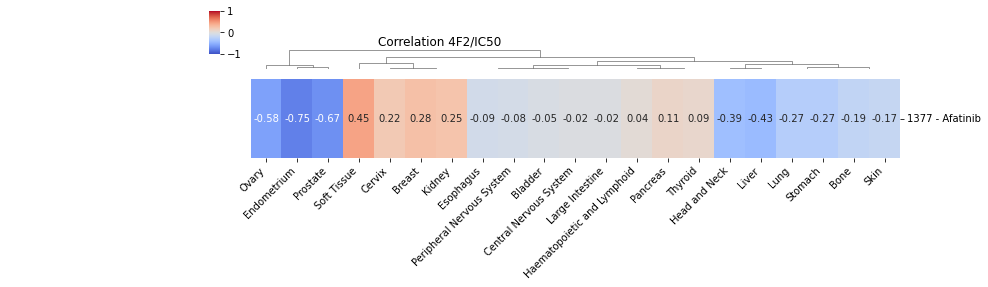

In [843]:
heatmap_drug_one(protein, drug)

/Users/scai/anaconda3/envs/sklearn22/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



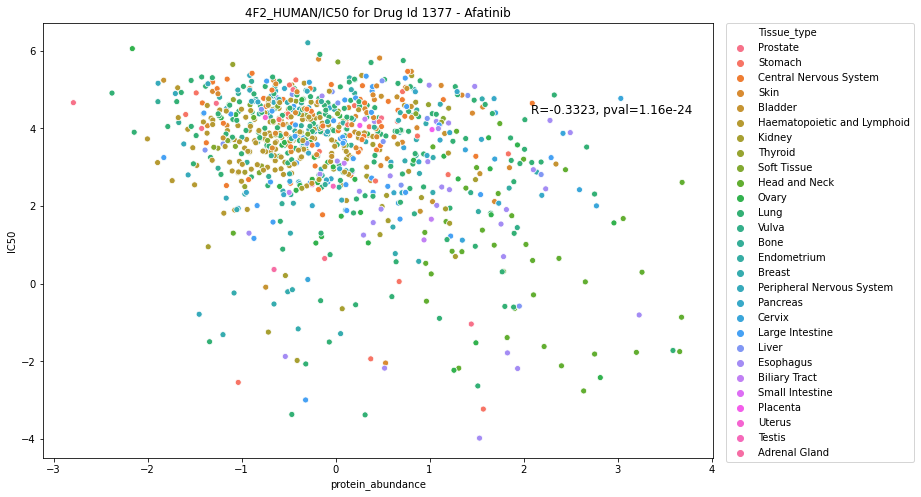

In [844]:
drug_scatter_one(protein, drug, x=0.85)

/Users/scai/anaconda3/envs/sklearn22/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



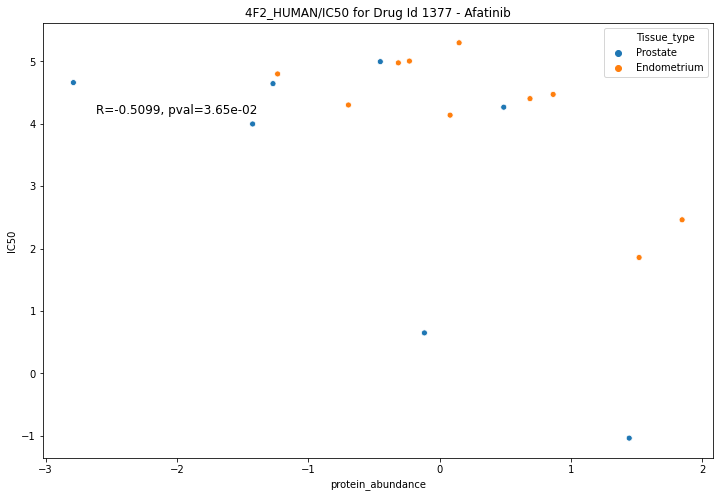

In [846]:
drug_scatter_one_tissue(protein, drug, ['Endometrium', 'Prostate'], x=0.2)

### other

In [ ]:
res_all_filtered_protein.groupby(
    ['tissue', 'target_pathway'])['pearson_correlation'].mean()

In [ ]:
sns.distplot()

In [168]:
drug_list = [1909, 1114, 1373, 1919, 1377, 119, 427, 1910, 1047]

In [169]:
res_all_filtered['pearson_correlation_abs'] = res_all_filtered['pearson_correlation'].abs()

/Users/scai/anaconda3/envs/sklearn22/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [170]:
res_all_filtered = res_all_filtered.sort_values(by=['pearson_correlation_abs'],
                                                ascending=False)

In [177]:
res_all_filtered[(res_all_filtered['drug_id'].isin(drug_list)) & (res_all_filtered['count'] > 10)].head(20)

Drug Id      protein       tissue  pearson_correlation  pearson_pval  \
58635     1910   BIN1_HUMAN  Soft Tissue            -0.949871      0.000008   
28924     1919   KTN1_HUMAN  Endometrium            -0.938751      0.000019   
67677     1373   RL10_HUMAN      Bladder             0.923270      0.000050   
49254     1377   HGH1_HUMAN       Cervix             0.921014      0.000057   
50164     1377   PKN2_HUMAN       Cervix             0.919252      0.000024   
20420     1114  UBE2T_HUMAN        Ovary             0.912403      0.000090   
20491     1047   VILI_HUMAN        Ovary            -0.912151      0.000036   
67069     1373   NPL4_HUMAN      Bladder             0.911118      0.000015   
49222     1377   HAT1_HUMAN       Cervix             0.908178      0.000110   
60813     1114   RISC_HUMAN  Soft Tissue             0.905659      0.000124   
65987     1373   DRG1_HUMAN      Bladder             0.905175      0.000127   
68413     1373   TTC1_HUMAN      Bladder             0.903014      0.000024   
51249     1377  TRXR1_HUMAN       Cervix             0.898705      0.000071   
51334     1377   ULA1_HUMAN       Cervix             0.897902      0.000073   
61287     1919  SUMF2_HUMAN  Soft Tissue             0.895514      0.000003   
21754      119  GSTO1_HUMAN         Skin             0.893332      0.000001   
28248     1919   DSG2_HUMAN  Endometrium            -0.891547      0.000228   
57123     1114   PRI1_HUMAN        Liver             0.890653      0.000236   
49065     1919  FSCN1_HUMAN       Cervix             0.890198      0.000045   
20774      119  APEX1_HUMAN         Skin             0.889973      0.000002   

       spearman_correlation  spearman_pval  count  pearson_correlation_abs  
58635             -0.945455       0.000011     11                 0.949871  
28924             -0.936364       0.000022     11                 0.938751  
67677              0.781818       0.004473     11                 0.923270  
49254              0.900000       0.000160     11                 0.921014  
50164              0.867133       0.000260     12                 0.919252  
20420              0.700000       0.016471     11                 0.912403  
20491             -0.895105       0.000084     12                 0.912151  
67069              0.741758       0.003701     13                 0.911118  
49222              0.945455       0.000011     11                 0.908178  
60813              0.918182       0.000067     11                 0.905659  
65987              0.663636       0.025984     11                 0.905175  
68413              0.785714       0.001454     13                 0.903014  
51249              0.797203       0.001900     12                 0.898705  
51334              0.923077       0.000019     12                 0.897902  
61287              0.873529       0.000010     16                 0.895514  
21754              0.708333       0.001461     17                 0.893332  
28248             -0.845455       0.001045     11                 0.891547  
57123              0.790909       0.003746     11                 0.890653  
49065              0.807692       0.000839     13                 0.890198  
20774              0.740196       0.000680     17                 0.889973

In [135]:
res_all_filtered_group = res_all_filtered.groupby(
    ['tissue', 'protein'])['pearson_pval'].mean().sort_values().reset_index()

In [136]:
res_all_filtered_group.head(10)

tissue      protein  pearson_pval
0  Haematopoietic and Lymphoid  ANXA7_HUMAN      0.105988
1                         Lung   LMNA_HUMAN      0.139006
2                      Thyroid   MUTA_HUMAN      0.142088
3                      Thyroid  NUCB2_HUMAN      0.143546
4                      Thyroid   PEPL_HUMAN      0.147214
5              Large Intestine  RDH14_HUMAN      0.150099
6              Large Intestine  OST48_HUMAN      0.152390
7                         Lung  RRBP1_HUMAN      0.153070
8                         Lung   K2C8_HUMAN      0.153118
9                         Bone  RRBP1_HUMAN      0.154249

In [172]:
cell_lines = tissue_cell_line['Lung']

In [173]:
drug_id = 1377
tmp_df = ic50[ic50['drug_id'] == drug_id].sort_values(
        by=['cell_line_name'])
cell_line_drug = tmp_df['cell_line_name'].values
protein_drug = protein_RUV[protein_RUV['Cell_line'].isin(cell_line_drug)]
ic50_drug = tmp_df[tmp_df['cell_line_name'].isin(
    protein_drug['Cell_line'])]
protein_drug_tissue = protein_drug[protein_drug['Cell_line'].isin(
            cell_lines)]
ic50_drug_tissue = ic50_drug[ic50_drug['cell_line_name'].isin(
    cell_lines)]

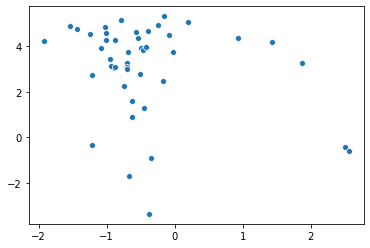

In [174]:
sns.scatterplot(protein_drug_tissue['ERBB2_HUMAN'].values, ic50_drug_tissue['ln_IC50'].values)

In [163]:
pearsonr(protein_drug_tissue['ERBB2_HUMAN'].values, ic50_drug_tissue['ln_IC50'].values)

(nan, 1.0)

In [175]:
res_all_filtered[(res_all_filtered['drug_id'] == 1377)
                 & (res_all_filtered['protein'] == 'ERBB2_HUMAN')]

Drug Id      protein                       tissue  pearson_correlation  \
69528     1377  ERBB2_HUMAN                    Esophagus            -0.778719   
7770      1377  ERBB2_HUMAN                      Stomach            -0.733547   
11201     1377  ERBB2_HUMAN                       Breast            -0.712240   
35218     1377  ERBB2_HUMAN                     Pancreas             0.588536   
28356     1377  ERBB2_HUMAN                  Endometrium             0.532791   
48942     1377  ERBB2_HUMAN                       Cervix             0.492432   
4339      1377  ERBB2_HUMAN                         Lung            -0.259975   
31787     1377  ERBB2_HUMAN       Central Nervous System             0.137703   
908       1377  ERBB2_HUMAN  Haematopoietic and Lymphoid             0.128586   
18063     1377  ERBB2_HUMAN                        Ovary            -0.116586   
14632     1377  ERBB2_HUMAN                         Bone            -0.087598   
45511     1377  ERBB2_HUMAN              Large Intestine             0.021831   

       pearson_pval  spearman_correlation  spearman_pval  count  \
69528      0.000379             -0.641176       0.007434     16   
7770       0.010192             -0.618182       0.042646     11   
11201      0.000021             -0.749863       0.000004     28   
35218      0.056813              0.509091       0.109737     11   
28356      0.218215              0.214286       0.644512      7   
48942      0.215094              0.333333       0.419753      8   
4339       0.084585             -0.140448       0.357461     45   
31787      0.638751             -0.032967       0.910919     14   
908        0.675468             -0.115385       0.707390     13   
18063      0.679035             -0.582143       0.022794     15   
14632      0.868939              0.085714       0.871743      6   
45511      0.923179              0.025409       0.910632     22   

       pearson_correlation_abs  
69528                 0.778719  
7770                  0.733547  
11201                 0.712240  
35218                 0.588536  
28356                 0.532791  
48942                 0.492432  
4339                  0.259975  
31787                 0.137703  
908                   0.128586  
18063                 0.116586  
14632                 0.087598  
45511                 0.021831

In [ ]:
res_all_filtered[(res_all_filtered['protein'] == protein)].groupby(['tissue']).mean

### new AIP

In [77]:
protein = 'VTNC_HUMAN'
drug = 1083

<ipython-input-36-63f5332f538c>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



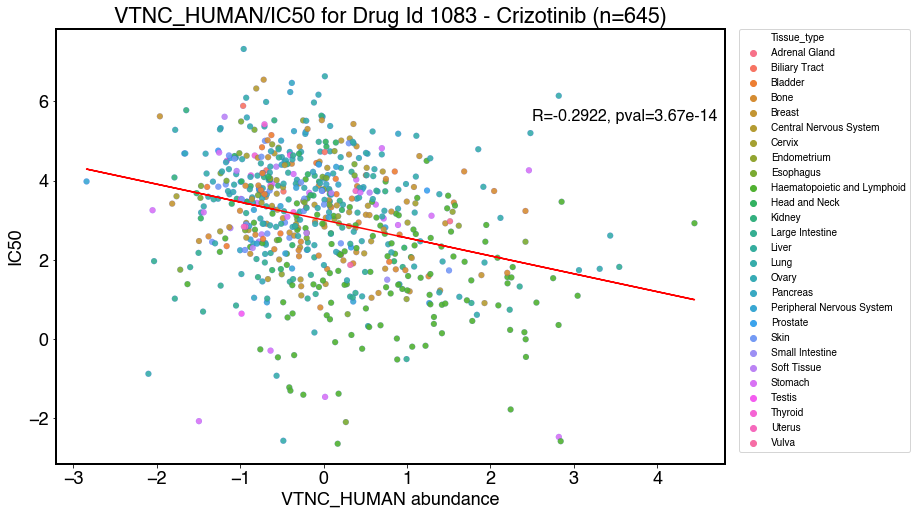

In [78]:
drug_scatter_one(protein, drug, protein_sample, ic50, x=0.85)

### 26S Proteasome

In [38]:
protein = 'PSA3_HUMAN'
drug = 1004

<ipython-input-36-63f5332f538c>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



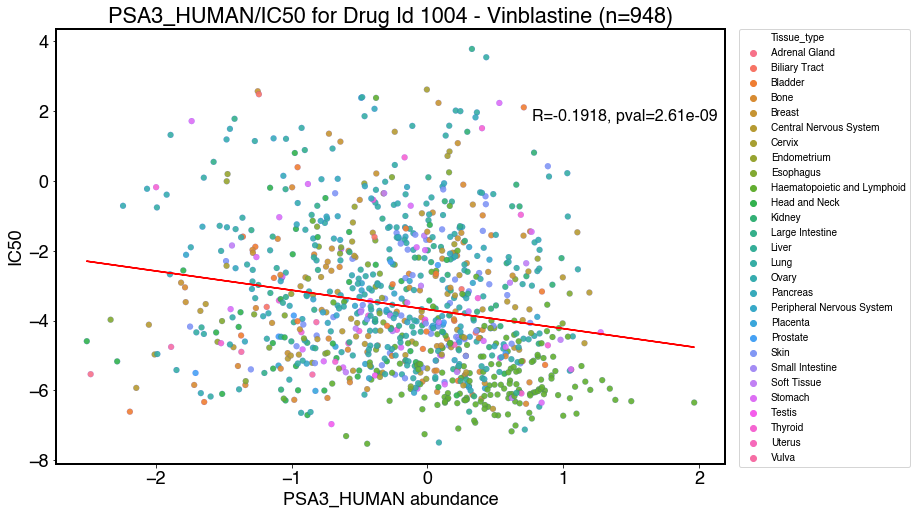

In [39]:
drug_scatter_one(protein, drug, protein_sample, ic50, x=0.85)

In [46]:
protein = 'PSMD8_HUMAN'
drug = 1919

<ipython-input-36-63f5332f538c>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



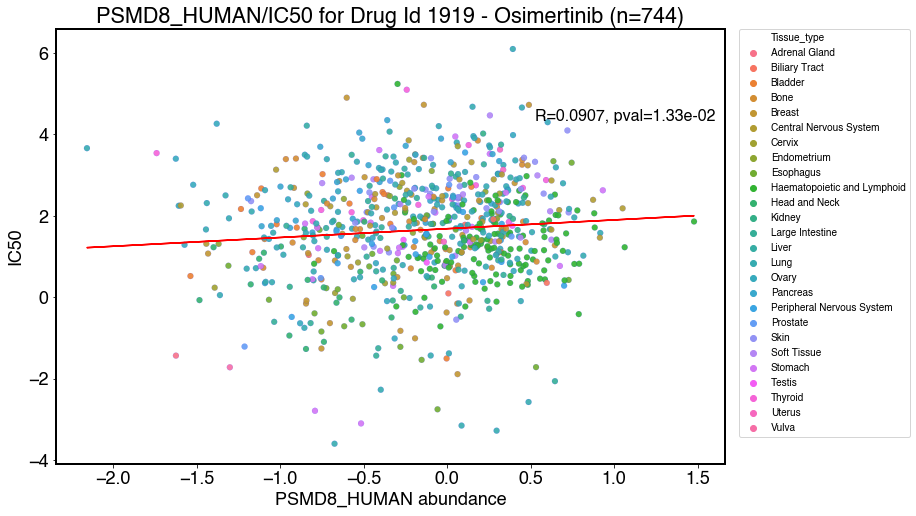

In [47]:
drug_scatter_one(protein, drug, protein_sample, ic50, x=0.85)

## protein vs RNA

### pan-cancer

In [258]:
res_all_rna_pancancer_noblood_common = res_all_rna_pancancer_noblood_common.rename(columns={'protein':'gene'})

res_pancancer_noblood_common_all['gene'] = res_pancancer_noblood_common_all['protein'].map(name_map_dict)

res_pancancer_merged = pd.merge(res_all_rna_pancancer_noblood_common,
                                res_pancancer_noblood_common_all,
                                on=['drug_id', 'gene'],
                                suffixes=['_rna', '_protein'])

In [259]:
# pickle.dump(res_pancancer_merged, open("../data/correlation/res_pancancer_merged_noblood_common.pkl", "wb"))

In [ ]:
res_pancancer_merged = pickle.load(open("../data/correlation/res_pancancer_merged.pkl", "rb"))

In [450]:
res_pancancer_merged['TARGET'] = res_pancancer_merged['drug_id'].map(drug_target_map)

In [451]:
res_pancancer_merged_filtered = res_pancancer_merged[
    (res_pancancer_merged['pearson_pval_rna'] < 0.01)
    & (res_pancancer_merged['pearson_pval_protein'] < 0.01)]

In [452]:
res_pancancer_merged_filtered[
    'pearson_delta'] = res_pancancer_merged_filtered.apply(lambda row: row[
        'pearson_correlation_protein'] - row['pearson_correlation_rna'], axis=1)

/Users/scai/anaconda3/envs/sklearn22/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [453]:
res_pancancer_merged_filtered = res_pancancer_merged_filtered[
    ((res_pancancer_merged_filtered['count_rna'] -
      res_pancancer_merged_filtered['count_protein']) < 100)]

res_pancancer_merged_filtered['Drug_Name'] = res_pancancer_merged_filtered[
    'drug_id'].map(drug_name_map)

res_pancancer_merged_filtered = res_pancancer_merged_filtered[
    res_pancancer_merged_filtered['drug_id'].isin(drug_list_sensitive)]

In [454]:
res_pancancer_merged_filtered = res_pancancer_merged_filtered[[
    'drug_id', 'Drug_Name', 'TARGET', 'gene', 'pearson_correlation_rna',
    'pearson_correlation_protein', 'pearson_delta','count_rna','count_protein'
]]

In [455]:
res_pancancer_merged_filtered_pos = res_pancancer_merged_filtered[
    (res_pancancer_merged_filtered['pearson_correlation_rna'] > 0)
    & (res_pancancer_merged_filtered['pearson_correlation_protein'] > 0)]
res_pancancer_merged_filtered_neg = res_pancancer_merged_filtered[
    (res_pancancer_merged_filtered['pearson_correlation_rna'] < 0)
    & (res_pancancer_merged_filtered['pearson_correlation_protein'] < 0)]

In [456]:
topN = 15

In [463]:
res_pancancer_merged_filtered.sort_values(
    by=['pearson_correlation_protein'], ascending=False).head(topN)

Drug Id   Drug_Name                         TARGET      gene  \
1813         51   Dasatinib  ABL, SRC, Ephrins, PDGFR, KIT     EPB41   
38531        51   Dasatinib  ABL, SRC, Ephrins, PDGFR, KIT     PRDX2   
7003         51   Dasatinib  ABL, SRC, Ephrins, PDGFR, KIT  MARCKSL1   
27222        51   Dasatinib  ABL, SRC, Ephrins, PDGFR, KIT       CKB   
10172        51   Dasatinib  ABL, SRC, Ephrins, PDGFR, KIT  PAFAH1B3   
15176        55    A-770041                       LCK, FYN     EPB41   
102801       51   Dasatinib  ABL, SRC, Ephrins, PDGFR, KIT     GLOD4   
6742         51   Dasatinib  ABL, SRC, Ephrins, PDGFR, KIT    ENOPH1   
9806         51   Dasatinib  ABL, SRC, Ephrins, PDGFR, KIT     PARP1   
11750        56    WH-4-023                       SRC, LCK     EPB41   
27984        51   Dasatinib  ABL, SRC, Ephrins, PDGFR, KIT     STMN1   
120        1909  Venetoclax                           BCL2      LMNA   
4830        431   Alisertib                          AURKA    SUCLG2   
114576       51   Dasatinib  ABL, SRC, Ephrins, PDGFR, KIT    ZNF428   
46094        56    WH-4-023                       SRC, LCK     PRDX2   

        pearson_correlation_rna  pearson_correlation_protein  pearson_delta  \
1813                   0.517088                     0.553944       0.036856   
38531                  0.337851                     0.530391       0.192540   
7003                   0.442326                     0.510211       0.067885   
27222                  0.360068                     0.494202       0.134134   
10172                  0.420740                     0.474480       0.053740   
15176                  0.397188                     0.465660       0.068471   
102801                 0.270461                     0.458805       0.188344   
6742                   0.444704                     0.455835       0.011131   
9806                   0.422914                     0.455143       0.032229   
11750                  0.412258                     0.454374       0.042116   
27984                  0.358402                     0.454221       0.095819   
120                    0.428146                     0.452830       0.024684   
4830                   0.276309                     0.445718       0.169410   
114576                 0.262589                     0.443414       0.180825   
46094                  0.325927                     0.439204       0.113277   

        count_rna  count_protein  
1813          241            164  
38531         241            238  
7003          241            233  
27222         241            181  
10172         241            240  
15176         241            164  
102801        241            232  
6742          241            226  
9806          241            241  
11750         241            164  
27984         241            240  
120           610            610  
4830          730            727  
114576        241            203  
46094         241            238

In [457]:
res_pancancer_merged_filtered_pos.sort_values(
    by=['pearson_delta'], ascending=False).head(topN).sort_values(['gene'])

Drug Id                 Drug_Name  \
336011     1855  KRAS (G12C) Inhibitor-12   
278454     1012                Vorinostat   
173184     1849                Sabutoclax   
362807     1085                 Sorafenib   
263494     1012                Vorinostat   
330409     1177                 Niraparib   
312051     1931                    MIRA-1   
316885     1080                Paclitaxel   
309599     1179                   MK-1775   
164684     1079                 Dasatinib   
318199     1012                Vorinostat   
169325     1849                Sabutoclax   
250103     1085                 Sorafenib   
237071     1849                Sabutoclax   
276272     1931                    MIRA-1   

                                      TARGET      gene  \
336011                           KRAS (G12C)     AP2B1   
278454  HDAC inhibitor Class I, IIa, IIb, IV     AP2B1   
173184            BCL2,  BCL-XL,  BFL1, MCL1     DDOST   
362807                PDGFR, KIT, VEGFR, RAF     ESYT1   
263494  HDAC inhibitor Class I, IIa, IIb, IV     ESYT1   
330409                          PARP1, PARP2     GLUD1   
312051                                  TP53      MESD   
316885                Microtubule stabiliser      MESD   
309599                            WEE1, PLK1      MMUT   
164684         ABL, SRC, Ephrins, PDGFR, KIT     PEBP1   
318199  HDAC inhibitor Class I, IIa, IIb, IV      RPN1   
169325            BCL2,  BCL-XL,  BFL1, MCL1      RPN1   
250103                PDGFR, KIT, VEGFR, RAF      RPN1   
237071            BCL2,  BCL-XL,  BFL1, MCL1  SLC25A24   
276272                                  TP53     TMED1   

        pearson_correlation_rna  pearson_correlation_protein  pearson_delta  \
336011                 0.112976                     0.351915       0.238939   
278454                 0.107212                     0.338162       0.230950   
173184                 0.149605                     0.402561       0.252957   
362807                 0.105753                     0.338809       0.233055   
263494                 0.109933                     0.337642       0.227708   
330409                 0.114074                     0.346681       0.232607   
312051                 0.114950                     0.370870       0.255920   
316885                 0.113531                     0.341651       0.228120   
309599                 0.113988                     0.355444       0.241456   
164684                 0.148414                     0.392952       0.244537   
318199                 0.100563                     0.356819       0.256256   
169325                 0.150761                     0.395384       0.244624   
250103                 0.126707                     0.363990       0.237282   
237071                 0.132895                     0.359511       0.226616   
276272                 0.121818                     0.376822       0.255004   

        count_rna  count_protein  
336011        581            581  
278454        776            776  
173184        581            581  
362807        611            611  
263494        776            776  
330409        580            579  
312051        605            603  
316885        611            609  
309599        620            611  
164684        611            602  
318199        776            776  
169325        581            581  
250103        611            611  
237071        581            579  
276272        605            587

In [458]:
res_pancancer_merged_filtered_neg.sort_values(
    by=['pearson_delta', 'pearson_correlation_rna'],
    ascending=True).head(topN).sort_values(['gene'])

Drug Id    Drug_Name                         TARGET      gene  \
98582        56     WH-4-023                       SRC, LCK     CRTAP   
99450      1377     Afatinib                    ERBB2, EGFR   CSNK1A1   
232888       94       TGX221                       PI3Kbeta      EMC7   
242543       51    Dasatinib  ABL, SRC, Ephrins, PDGFR, KIT      EMC7   
257509       94       TGX221                       PI3Kbeta       EMD   
76260        51    Dasatinib  ABL, SRC, Ephrins, PDGFR, KIT     ESYT1   
364655     1526  Refametinib                     MEK1, MEK2     FTSJ3   
341011       51    Dasatinib  ABL, SRC, Ephrins, PDGFR, KIT      NCLN   
137157       51    Dasatinib  ABL, SRC, Ephrins, PDGFR, KIT      RPN1   
312123       56     WH-4-023                       SRC, LCK      RPN1   
139774       51    Dasatinib  ABL, SRC, Ephrins, PDGFR, KIT    SLC3A2   
250980       56     WH-4-023                       SRC, LCK    SPECC1   
220886       51    Dasatinib  ABL, SRC, Ephrins, PDGFR, KIT     SRPRA   
335017       51    Dasatinib  ABL, SRC, Ephrins, PDGFR, KIT      TBL2   
143733       51    Dasatinib  ABL, SRC, Ephrins, PDGFR, KIT  TOR1AIP2   

        pearson_correlation_rna  pearson_correlation_protein  pearson_delta  \
98582                 -0.273455                    -0.472503      -0.199048   
99450                 -0.157524                    -0.383441      -0.225917   
232888                -0.206747                    -0.463316      -0.256569   
242543                -0.203722                    -0.441244      -0.237522   
257509                -0.198217                    -0.403226      -0.205009   
76260                 -0.291518                    -0.491349      -0.199831   
364655                -0.098397                    -0.299587      -0.201190   
341011                -0.173844                    -0.447231      -0.273387   
137157                -0.249100                    -0.484198      -0.235098   
312123                -0.181761                    -0.388678      -0.206918   
139774                -0.247599                    -0.441519      -0.193919   
250980                -0.200826                    -0.421646      -0.220819   
220886                -0.211516                    -0.417798      -0.206282   
335017                -0.175422                    -0.384841      -0.209419   
143733                -0.245494                    -0.451129      -0.205635   

        count_rna  count_protein  
98582         241            218  
99450         737            690  
232888        242            238  
242543        241            237  
257509        242            242  
76260         241            241  
364655        702            701  
341011        241            241  
137157        241            241  
312123        241            241  
139774        241            241  
250980        241            182  
220886        241            240  
335017        241            241  
143733        241            196

In [459]:
res_pancancer_merged_filtered_pos.sort_values(
    by=['pearson_delta'], ascending=True).head(topN).sort_values(['gene'])

Drug Id          Drug_Name                             TARGET      gene  \
499      1804           Acetalax                                NaN    CEP170   
693       264           ACY-1215                              HDAC6     CLIC1   
1106     1910             ABT737  BCL2, BCL-XL,  BCL-W, BCL-B, BFL1     CLIP1   
402      1242  (5Z)-7-Oxozeaenol                               TAK1     EPPK1   
542      1371           PLX-4720                               BRAF     EPPK1   
317      1909         Venetoclax                               BCL2      FLII   
162       449              CD532                              AURKA     KRT80   
817      1849         Sabutoclax         BCL2,  BCL-XL,  BFL1, MCL1     KRT80   
52       1910             ABT737  BCL2, BCL-XL,  BCL-W, BCL-B, BFL1      MYOF   
7        1909         Venetoclax                               BCL2      MYOF   
3768       51          Dasatinib      ABL, SRC, Ephrins, PDGFR, KIT   NDUFAF4   
219      1910             ABT737  BCL2, BCL-XL,  BCL-W, BCL-B, BFL1     PLIN3   
69       1910             ABT737  BCL2, BCL-XL,  BCL-W, BCL-B, BFL1      RHOC   
788      1910             ABT737  BCL2, BCL-XL,  BCL-W, BCL-B, BFL1      RRAS   
1226     1910             ABT737  BCL2, BCL-XL,  BCL-W, BCL-B, BFL1  SERPINB6   

      pearson_correlation_rna  pearson_correlation_protein  pearson_delta  \
499                  0.393676                     0.132317      -0.261359   
693                  0.339055                     0.103381      -0.235674   
1106                 0.358266                     0.116937      -0.241329   
402                  0.359929                     0.095019      -0.264910   
542                  0.346784                     0.097071      -0.249713   
317                  0.399412                     0.149412      -0.250000   
162                  0.382420                     0.107034      -0.275386   
817                  0.375899                     0.124141      -0.251757   
52                   0.455650                     0.138215      -0.317436   
7                    0.491732                     0.229122      -0.262610   
3768                 0.477562                     0.167670      -0.309891   
219                  0.412087                     0.145579      -0.266508   
69                   0.449558                     0.208891      -0.240667   
788                  0.370097                     0.128376      -0.241720   
1226                 0.354554                     0.111783      -0.242771   

      count_rna  count_protein  
499         581            508  
693         747            747  
1106        605            523  
402         735            735  
542         748            748  
317         610            604  
162         749            663  
817         581            531  
52          605            605  
7           610            610  
3768        241            240  
219         605            589  
69          605            541  
788         605            563  
1226        605            541

In [460]:
res_pancancer_merged_filtered_neg.sort_values(
    by=['pearson_delta', 'pearson_correlation_rna'],
    ascending=False).head(topN).sort_values(['gene'])

Drug Id          Drug_Name                         TARGET     gene  \
225      1079          Dasatinib  ABL, SRC, Ephrins, PDGFR, KIT  COL12A1   
212      1526        Refametinib                     MEK1, MEK2   CTNNB1   
758        51          Dasatinib  ABL, SRC, Ephrins, PDGFR, KIT     EHD2   
2623       51          Dasatinib  ABL, SRC, Ephrins, PDGFR, KIT    ERAP1   
236      1378  Bleomycin (50 uM)          dsDNA break induction    FSCN1   
425        51          Dasatinib  ABL, SRC, Ephrins, PDGFR, KIT    HSPG2   
3828      119          Lapatinib                    EGFR, ERBB2    ITGB4   
196      1377           Afatinib                    ERBB2, EGFR    LAMC2   
2142       51          Dasatinib  ABL, SRC, Ephrins, PDGFR, KIT    LASP1   
245        51          Dasatinib  ABL, SRC, Ephrins, PDGFR, KIT     MYOF   
969        51          Dasatinib  ABL, SRC, Ephrins, PDGFR, KIT     NT5E   
1960       94             TGX221                       PI3Kbeta    NUCB1   
3807       51          Dasatinib  ABL, SRC, Ephrins, PDGFR, KIT    PEA15   
1411       51          Dasatinib  ABL, SRC, Ephrins, PDGFR, KIT      PXN   
2475       51          Dasatinib  ABL, SRC, Ephrins, PDGFR, KIT   SQSTM1   

      pearson_correlation_rna  pearson_correlation_protein  pearson_delta  \
225                 -0.408480                    -0.109221       0.299259   
212                 -0.385724                    -0.111926       0.273797   
758                 -0.559307                    -0.290282       0.269026   
2623                -0.497479                    -0.242781       0.254698   
236                 -0.368896                    -0.103696       0.265199   
425                 -0.587200                    -0.251746       0.335453   
3828                -0.480268                    -0.189764       0.290503   
196                 -0.379040                    -0.105728       0.273312   
2142                -0.508100                    -0.236444       0.271656   
245                 -0.607040                    -0.334441       0.272599   
969                 -0.548269                    -0.234222       0.314048   
1960                -0.512343                    -0.235845       0.276498   
3807                -0.476939                    -0.208220       0.268719   
1411                -0.530208                    -0.224043       0.306165   
2475                -0.500395                    -0.236026       0.264370   

      count_rna  count_protein  
225         611            571  
212         702            687  
758         241            181  
2623        241            143  
236         756            735  
425         241            153  
3828        237            227  
196         737            707  
2142        241            241  
245         241            241  
969         241            166  
1960        242            239  
3807        241            232  
1411        241            150  
2475        241            191

#### RPN1

/Users/scai/anaconda3/envs/sklearn22/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



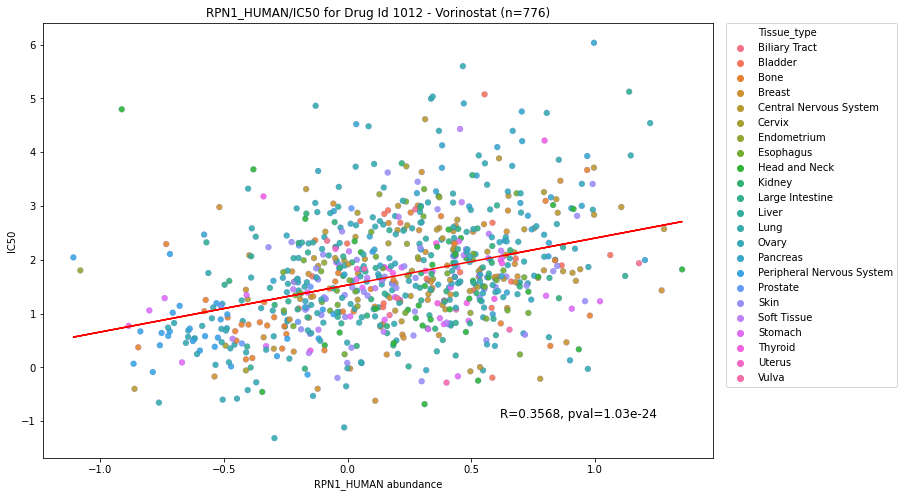

In [428]:
drug_scatter_one('RPN1_HUMAN', 1012, protein_sample, ic50_noblood, y=0.1)

/Users/scai/anaconda3/envs/sklearn22/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



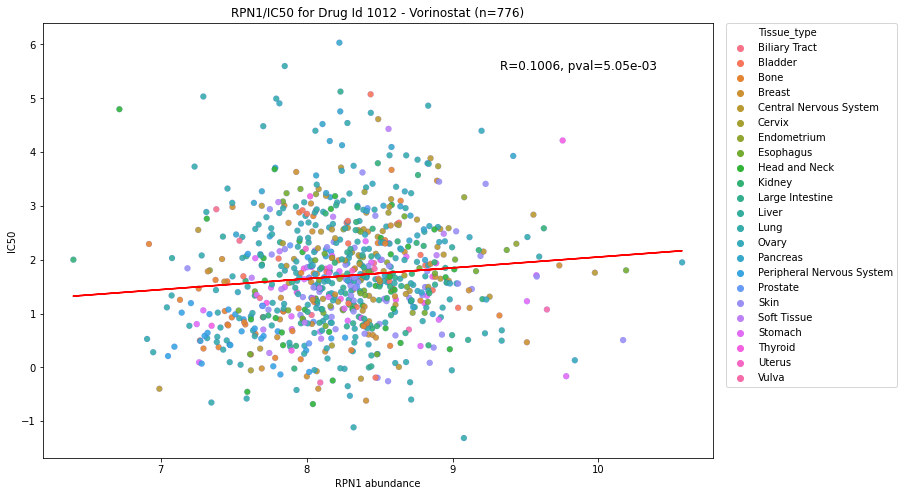

In [429]:
drug_scatter_one('RPN1', 1012, rna_sample, ic50_noblood, x=0.8, y=0.9)

/Users/scai/anaconda3/envs/sklearn22/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



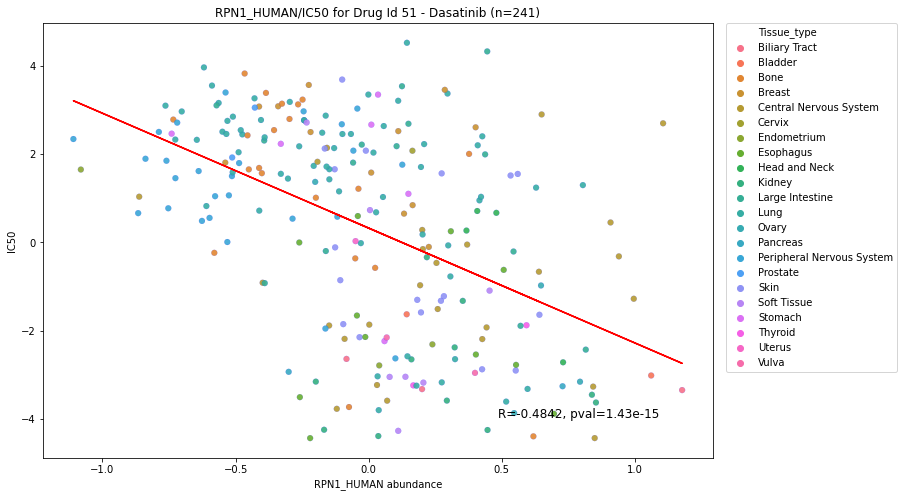

In [430]:
drug_scatter_one('RPN1_HUMAN', 51, protein_sample, ic50_noblood, y=0.1)

/Users/scai/anaconda3/envs/sklearn22/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



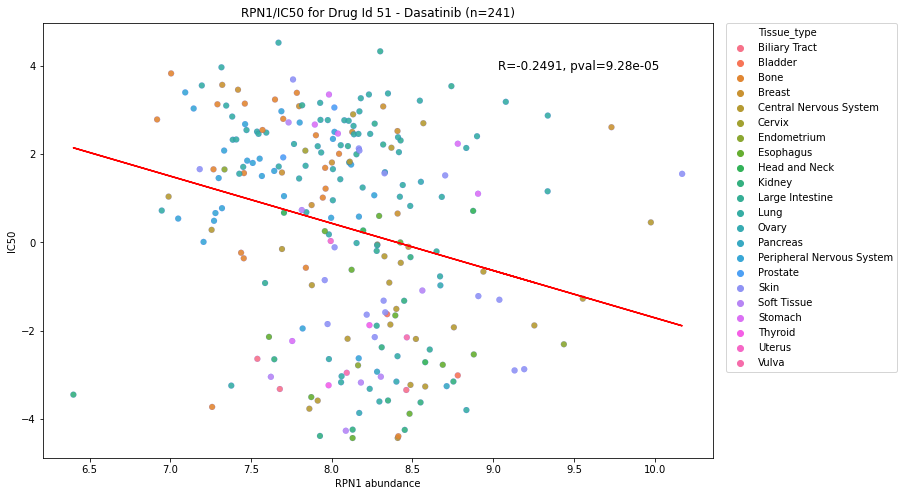

In [431]:
drug_scatter_one('RPN1', 51, rna_sample, ic50_noblood, x=0.8, y=0.9)

/Users/scai/anaconda3/envs/sklearn22/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/scai/anaconda3/envs/sklearn22/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



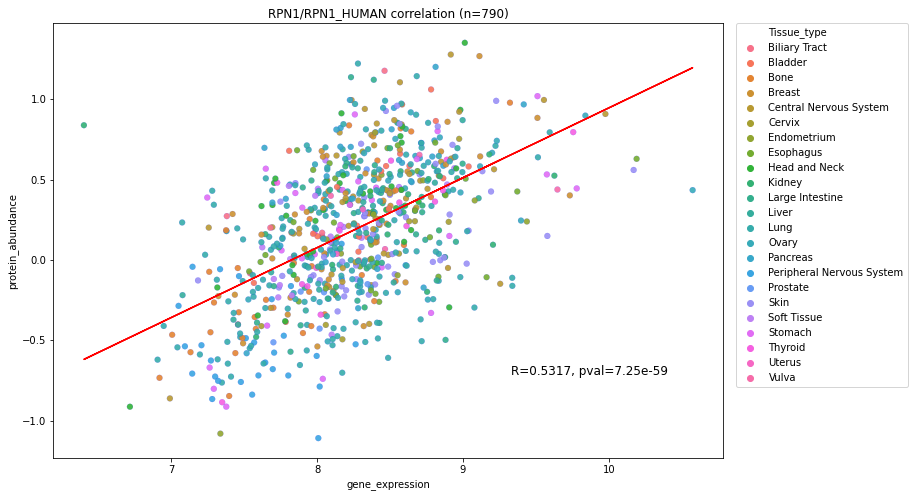

In [443]:
rna_protein_scatter('RPN1','RPN1_HUMAN', rna_sample, protein_sample, ic50_noblood_common, y=0.2)

/Users/scai/anaconda3/envs/sklearn22/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/scai/anaconda3/envs/sklearn22/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



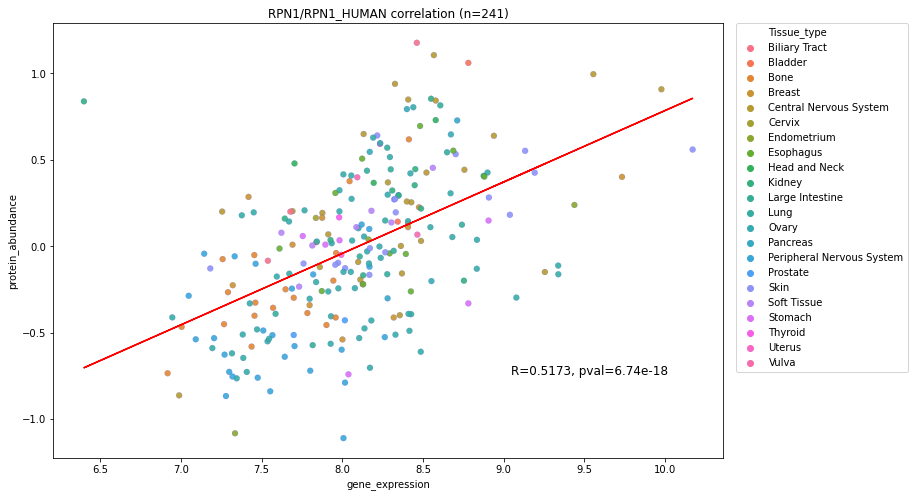

In [442]:
rna_protein_scatter('RPN1','RPN1_HUMAN', rna_sample, protein_sample, ic50_noblood_common, y=0.2, drug=51)

#### MYOF

/Users/scai/anaconda3/envs/sklearn22/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



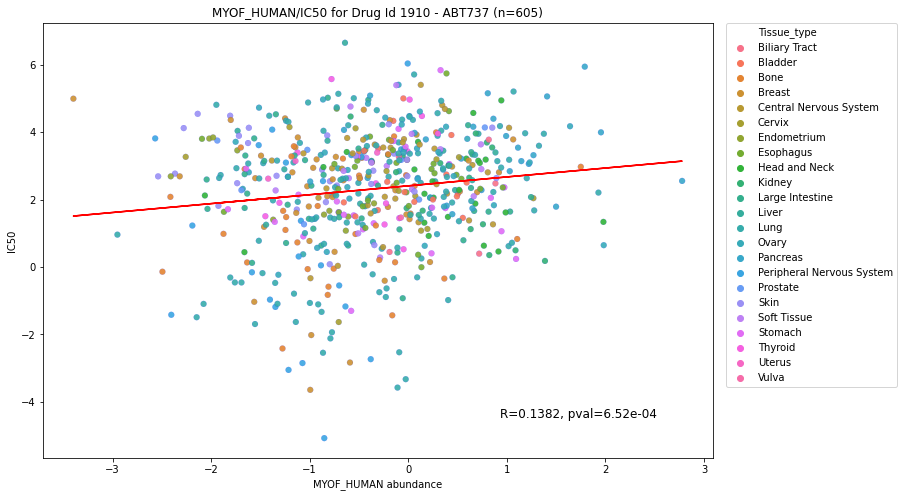

In [432]:
drug_scatter_one('MYOF_HUMAN', 1910, protein_sample, ic50_noblood, y=0.1)

/Users/scai/anaconda3/envs/sklearn22/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



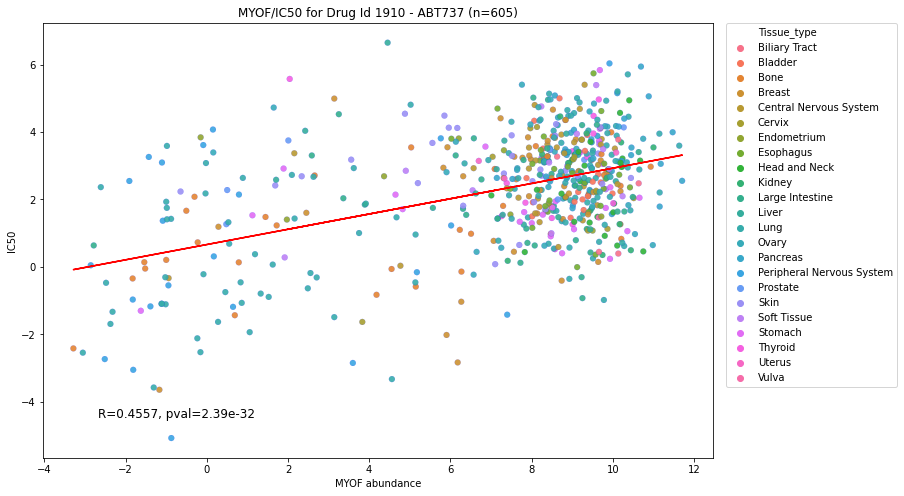

In [433]:
drug_scatter_one('MYOF', 1910, rna_sample, ic50_noblood, x=0.2, y=0.1)

/Users/scai/anaconda3/envs/sklearn22/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



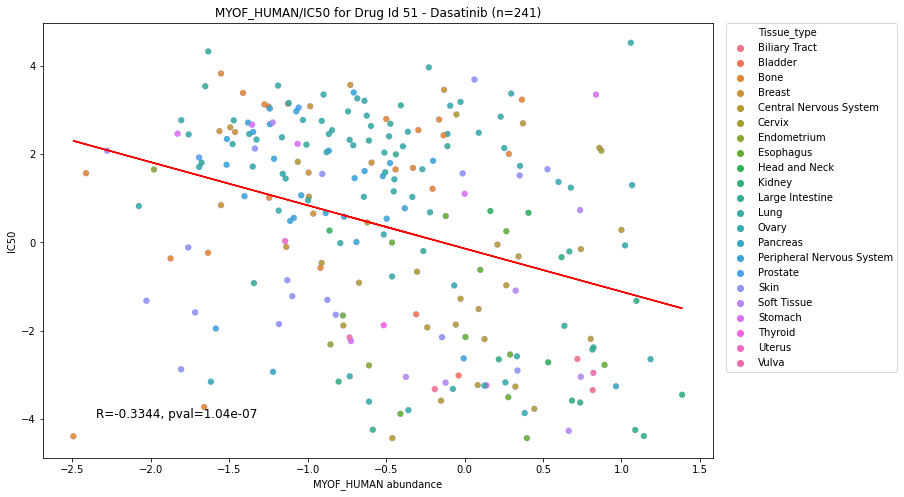

In [437]:
drug_scatter_one('MYOF_HUMAN', 51, protein_sample, ic50_noblood, x=0.2, y=0.1)

/Users/scai/anaconda3/envs/sklearn22/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



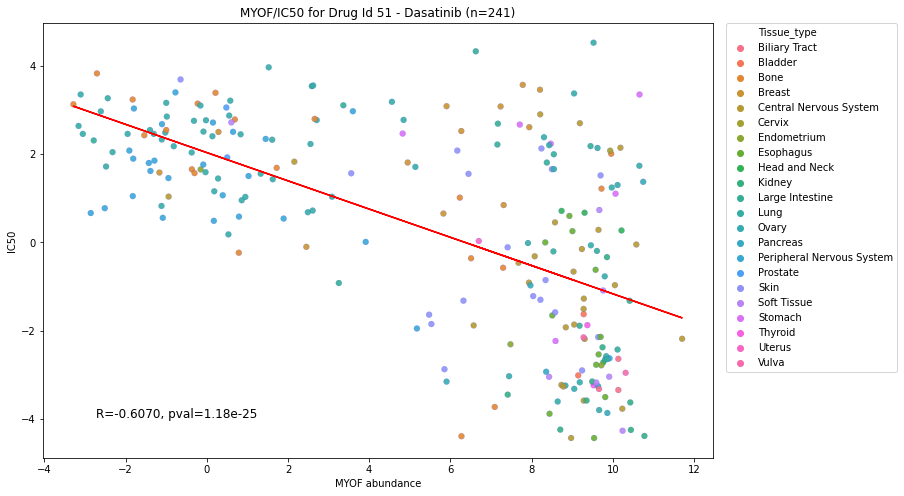

In [436]:
drug_scatter_one('MYOF', 51, rna_sample, ic50_noblood, x=0.2, y=0.1)

/Users/scai/anaconda3/envs/sklearn22/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/scai/anaconda3/envs/sklearn22/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



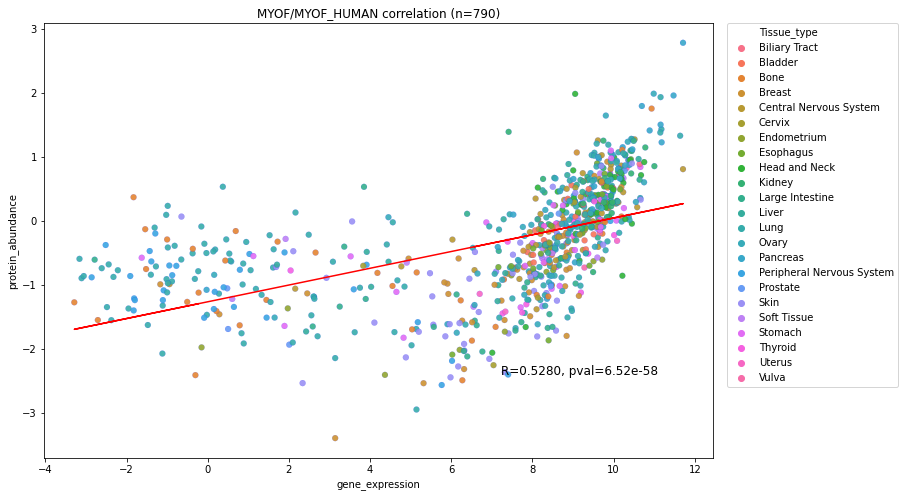

In [444]:
rna_protein_scatter('MYOF','MYOF_HUMAN', rna_sample, protein_sample, ic50_noblood_common, y=0.2)

/Users/scai/anaconda3/envs/sklearn22/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/scai/anaconda3/envs/sklearn22/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



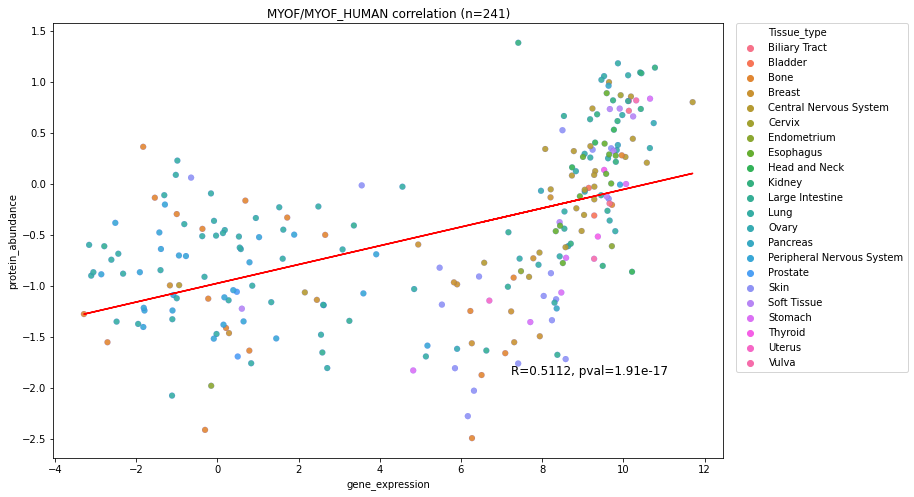

In [445]:
rna_protein_scatter('MYOF','MYOF_HUMAN', rna_sample, protein_sample, ic50_noblood_common, y=0.2, drug=51)

# all pan-drug

In [38]:
name_map = pd.read_csv("../data/misc/HUMAN_9606_idmapping.gene_prot.dat",
                       sep='\t',
                       names=['ID', 'type', 'code'])
name_map = name_map.drop_duplicates(['ID', 'type'])
name_map = pd.pivot(name_map, index='ID', columns='type', values='code').dropna()

name_map_dict = dict(zip(name_map['UniProtKB-ID'].values, name_map['Gene_Name'].values))

In [40]:
druggable = pd.read_csv("../data/drug/archive/druggable_proteome.tsv", sep='\t')


In [41]:
res_df_filtered_druggable = res_df_filtered[res_df_filtered['protein'].map(
    name_map_dict).isin(druggable['Gene'].unique())]

(-0.7, 0.7)

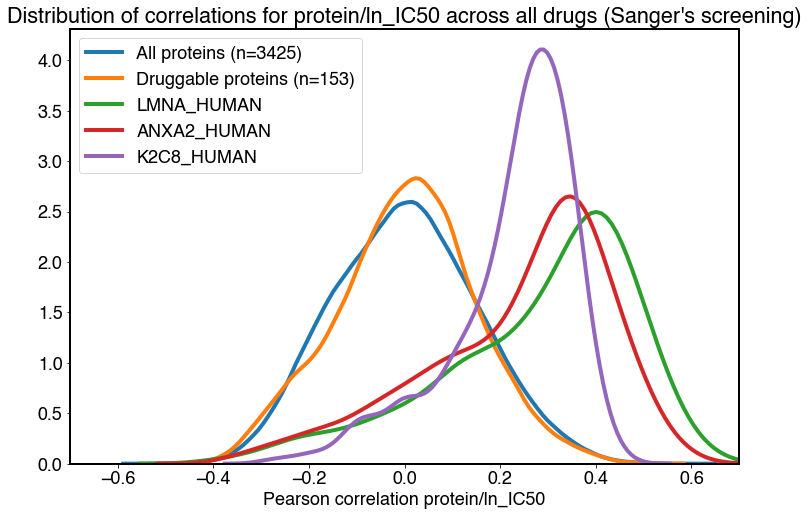

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8), sharex=True)
plt.title(
    "Distribution of correlations for protein/ln_IC50 across all drugs (Sanger's screening)"
)
sns.distplot(res_df_filtered['pearson_correlation'],
             label=f"All proteins (n={res_df_filtered['protein'].unique().size})",
             hist=False,
             kde_kws=dict(linewidth=4))
sns.distplot(res_df_filtered_druggable['pearson_correlation'],
             label=f"Druggable proteins (n={res_df_filtered_druggable['protein'].unique().size})",
             hist=False,
             kde_kws=dict(linewidth=4))
sns.distplot(res_df_filtered[res_df_filtered['protein'] == "LMNA_HUMAN"]
             ['pearson_correlation'],
             label='LMNA_HUMAN',
             hist=False,
             kde_kws=dict(linewidth=4))
sns.distplot(res_df_filtered[res_df_filtered['protein'] == "ANXA2_HUMAN"]
             ['pearson_correlation'],
             label='ANXA2_HUMAN',
             hist=False,
             kde_kws=dict(linewidth=4))
sns.distplot(res_df_filtered[res_df_filtered['protein'] == "K2C8_HUMAN"]
             ['pearson_correlation'],
             label='K2C8_HUMAN',
             hist=False,
             kde_kws=dict(linewidth=4))
plt.xlabel("Pearson correlation protein/ln_IC50")
plt.xlim(-0.7, 0.7)

(-0.7, 0.7)

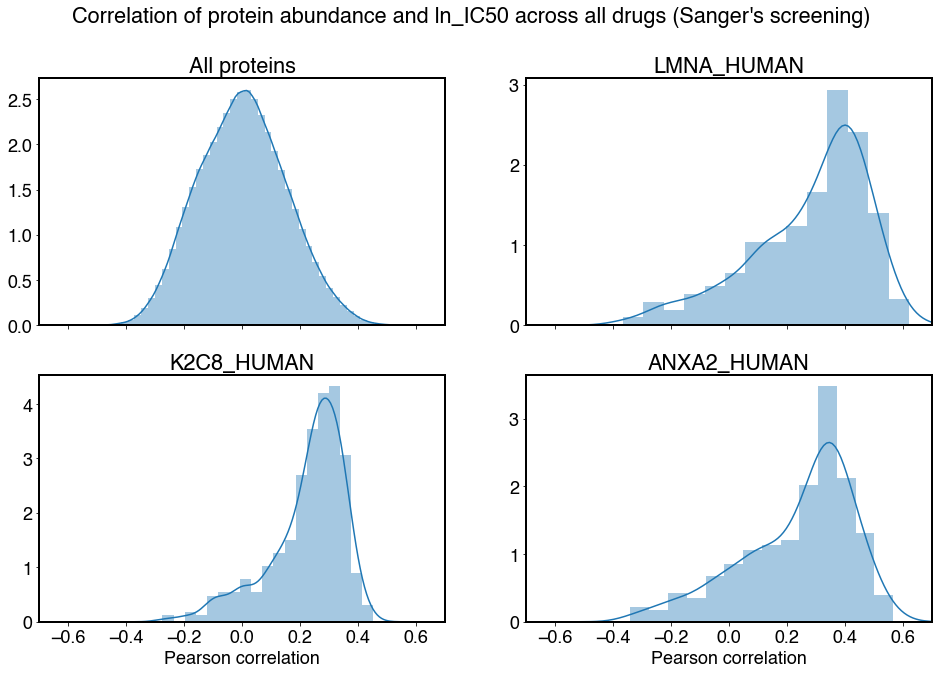

In [43]:
fig, ax = plt.subplots(2, 2, figsize=(16, 10), sharex=True)
fig.suptitle("Correlation of protein abundance and ln_IC50 across all drugs (Sanger's screening)")
sns.distplot(res_df_filtered['pearson_correlation'], ax=ax[0, 0])
sns.distplot(res_df_filtered[res_df_filtered['protein'] ==
                                      "LMNA_HUMAN"]['pearson_correlation'],
             ax=ax[0, 1])
sns.distplot(res_df_filtered[res_df_filtered['protein'] ==
                                      "K2C8_HUMAN"]['pearson_correlation'],
             ax=ax[1, 0])
sns.distplot(res_df_filtered[res_df_filtered['protein'] ==
                                      "ANXA2_HUMAN"]['pearson_correlation'],
             ax=ax[1, 1])
ax[0][0].set_title("All proteins")
ax[0][1].set_title("LMNA_HUMAN")
ax[1][0].set_title("K2C8_HUMAN")
ax[1][1].set_title("ANXA2_HUMAN")

ax[0][0].set_xlabel("")
ax[0][1].set_xlabel("")
ax[1][0].set_xlabel("Pearson correlation")
ax[1][1].set_xlabel("Pearson correlation")
plt.xlim(-0.7, 0.7)

In [29]:
protein_RUV = pd.read_csv("../data/protein/E0022_P06_Protein_Matrix_ProNorM_no_control.txt", sep='\t')

df_broad = pd.read_csv('../data/ccle/protein_quant_current_normalized.csv')
df_broad = df_broad.drop(
    ['Protein_Id', 'Gene_Symbol', 'Description', 'Group_ID', 'Uniprot_Acc'],
    axis=1).rename(columns={
        'Uniprot': 'Protein'
    }).set_index('Protein')
df_broad = df_broad.drop([
    'SW948_LARGE_INTESTINE_TenPx11', 'CAL120_BREAST_TenPx02',
    'HCT15_LARGE_INTESTINE_TenPx30'
],
                         axis=1)
rename_dict = {}
for x in df_broad.columns.to_list():
    rename_dict[x] = x.split('_TenPx')[0]
df_broad = df_broad.rename(columns=rename_dict)
df_broad = df_broad.drop(
    [x for x in df_broad.columns.tolist() if 'TenPx' in x],
    axis=1).transpose()

curr_dict = meta[['CCLE_ID','Cell_line']].drop_duplicates().set_index('CCLE_ID').to_dict()['Cell_line']
df_broad.index = df_broad.index.map(curr_dict)

common_lines_broad = [x for x in df_broad.index.tolist() if x in protein_RUV['Cell_line'].values]
print('Number of common cell lines: ',len(common_lines_broad))

len(set(common_lines_broad))
df_broad.index.name = 'Cell_line'
ccle_protein = df_broad.reset_index()

Number of common cell lines:  295
